In [1]:
import numpy as np
import os
import copy
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy.constants import mu_0
%matplotlib inline
import sys
sys.path.insert(0, os.path.abspath('.'))
sys.path.append(os.path.abspath('../'))
import functools

import jax
import jax.numpy as jnp
from jax import jit, jacfwd

from netCDF4 import Dataset
import h5py

from desc.basis import FourierZernikeBasis, DoubleFourierSeries, FourierSeries
# from desc.boundary_conditions import get_boundary_condition, LCFSConstraint
from desc.equilibrium import EquilibriaFamily, Equilibrium
from desc.grid import ConcentricGrid, LinearGrid, Grid, QuadratureGrid
from desc.io import InputReader, load
from desc.objective_funs import get_objective_function, ForceErrorNodes
from desc.plotting import plot_1d, plot_2d, plot_3d, plot_section, plot_surfaces
from desc.transform import Transform
from desc.vmec import VMECIO
from desc.derivatives import Derivative
import desc.compute_funs

from desc.utils import flatten_list
%load_ext line_profiler
os.getcwd()

DESC version 0.4.12+40.gc28d2a7.dirty, using JAX backend, jax version=0.2.10, jaxlib version=0.1.62, dtype=float64
Using device: CPU, with 3.57 GB available memory


'/home/fouriest/SCHOOL/Princeton/PPPL/DESC_freeb/local'

In [2]:
from desc.magnetic_fields import SplineMagneticField, ScalarPotentialField

def phi_lm(R,phi,Z, a, m):
    CNm0 = (R**m - R**-m)/(2*m)
    Nm1 = CNm0*Z
    CDm0 = (R**m + R**-m)/2
    c1 = -m*(m-1)
    c2 = (m+1)*(m-2)
    c3 = m*(m+1)
    c4 = -(m+2)*(m-1)
    CDm1 = (c1*R**(m+2) + c2*R**(m) + c3*R**(-m+2) + c4*R**(-m))/(8*m*(m**2-1))
    Dm2 = CDm0*Z**2/2 + CDm1
    return phi + a*Dm2*jnp.sin(m*phi) + a*Nm1*jnp.cos(m*phi)

    

    
a = -1.489
m = 5
args = (a,m)
field = ScalarPotentialField(phi_lm, args)
vacin = Dataset("../tests/inputs/nestor/ref_in/vacin_test.vmec_000000.nc","r")
mgrid = "../tests/inputs/nestor/mgrid_test.nc"
NFP     = int(vacin['nfp'][()])
extcur = vacin['extcur'][()]        
folder = os.getcwd()
mgridFilename = os.path.join(folder, mgrid)
ext_field = SplineMagneticField.from_mgrid(mgridFilename, extcur, extrap=True, period=(0,2*np.pi/NFP,0))


In [3]:
from jax.experimental.ode import odeint

def field_line_integrate(
    r0, z0, phis, field, params=(), rtol=1e-8, atol=1e-8, maxstep=1000
):
    """Trace field lines by integration

    Parameters
    ----------
    r0, z0 : array-like
        initial starting coordinates for r,z on phi=phis[0] plane
    phis : array-like
        strictly increasing array of toroidal angles to output r,z at
        Note that phis is the geometric toroidal angle for positive Bphi,
        and the negative toroidal angle for negative Bphi
    field : MagneticField
        source of magnetic field to integrate
    params: tuple
        parameters passed to field
    rtol, atol : float
        relative and absolute tolerances for ode integration
    maxstep : int
        maximum number of steps between different phis

    Returns
    -------
    r, z : ndarray
        arrays of r, z coordinates at specified phi angles

    """
    r0, z0 = map(jnp.asarray, (r0, z0))
    assert r0.shape == z0.shape, "r0 and z0 must have the same shape"
    rshape = r0.shape
    r0 = r0.flatten()
    z0 = z0.flatten()
    x0 = jnp.array([r0, phis[0] * jnp.ones_like(r0), z0]).T

    @jit
    def odefun(rpz, s):
        rpz = rpz.reshape((3, -1)).T
        r = rpz[:, 0]
        br, bp, bz = field.compute_magnetic_field(rpz, params).T
        return jnp.array(
            [r * br / bp * jnp.sign(bp), jnp.sign(bp), r * bz / bp * jnp.sign(bp)]
        ).squeeze()

    intfun = lambda x: odeint(odefun, x, phis, rtol=rtol, atol=atol, mxstep=maxstep)
    x = jnp.vectorize(intfun, signature="(k)->(n,k)")(x0)
    r = x[:, :, 0].T.reshape((len(phis), *rshape))
    z = x[:, :, 2].T.reshape((len(phis), *rshape))
    return r, z


In [4]:
import numpy as np
from abc import ABC, abstractmethod
from netCDF4 import Dataset
import math

from desc.backend import jnp, jit
from desc.io import IOAble
from desc.grid import Grid
from desc.interpolate import interp3d
from desc.derivatives import Derivative


class MagneticField(IOAble, ABC):
    """Base class for all magnetic fields

    Subclasses must implement the "compute_magnetic_field" method

    """

    _io_attrs_ = []

    def __mul__(self, x):
        if np.isscalar(x):
            return ScaledMagneticField(x, self)
        else:
            return NotImplemented

    def __rmul__(self, x):
        return self.__mul__(x)

    def __add__(self, x):
        if isinstance(x, MagneticField):
            return SumMagneticField(self, x)
        else:
            return NotImplemented

    def __neg__(self):
        return ScaledMagneticField(-1, self)

    def __sub__(self, x):
        return self.__add__(-x)

    @abstractmethod
    def compute_magnetic_field(self, coords, params=None, dR=0, dp=0, dZ=0):
        """Compute magnetic field at a set of points

        Parameters
        ----------
        coords : array-like shape(N,3) or Grid
            cylindrical coordinates to evaluate field at [R,phi,Z]
        params : tuple, optional
            parameters to pass to scalar potential function
        dR, dp, dZ : int, optional
            order of derivative to take in R,phi,Z directions

        Returns
        -------
        field : ndarray, shape(N,3)
            magnetic field at specified points, in cylindrical form [BR, Bphi,BZ]

        """

    def __call__(self, coords, params=None, dR=0, dp=0, dZ=0):
        return self.compute_magnetic_field(coords, params, dR, dp, dZ)


class ScaledMagneticField(MagneticField):
    """Magnetic field scaled by a scalar value

    ie B_new = scalar * B_old

    Parameters
    ----------
    scalar : float, int
        scaling factor for magnetic field
    field : MagneticField
        base field to be scaled

    """

    _io_attrs = MagneticField._io_attrs_ + ["_field", "_scalar"]

    def __init__(self, scalar, field):
        assert np.isscalar(scalar), "scalar must actually be a scalar value"
        assert isinstance(
            field, MagneticField
        ), "field should be a subclass of MagneticField, got type {}".format(
            type(field)
        )
        self._scalar = scalar
        self._field = field

    def compute_magnetic_field(self, coords, params=None, dR=0, dp=0, dZ=0):
        """Compute magnetic field at a set of points

        Parameters
        ----------
        coords : array-like shape(N,3) or Grid
            cylindrical coordinates to evaluate field at [R,phi,Z]
        params : tuple, optional
            parameters to pass to scalar potential function
        dR, dp, dZ : int, optional
            order of derivative to take in R,phi,Z directions

        Returns
        -------
        field : ndarray, shape(N,3)
            scaled magnetic field at specified points, in cylindrical
            form [BR, Bphi,BZ]

        """
        return self._scalar * self._field.compute_magnetic_field(
            coords, params, dR, dp, dZ
        )


class SumMagneticField(MagneticField):
    """Sum of two or more magnetic field sources

    Parameters
    ----------
    fields : MagneticField
        two or more MagneticFields to add together
    """

    _io_attrs = MagneticField._io_attrs_ + ["_fields"]

    def __init__(self, *fields):
        assert all(
            [isinstance(field, MagneticField) for field in fields]
        ), "fields should each be a subclass of MagneticField, got {}".format(
            [type(field) for field in fields]
        )
        self._fields = fields

    def compute_magnetic_field(self, coords, params=None, dR=0, dp=0, dZ=0):
        """Compute magnetic field at a set of points

        Parameters
        ----------
        coords : array-like shape(N,3) or Grid
            cylindrical coordinates to evaluate field at [R,phi,Z]
        params : tuple, optional
            parameters to pass to scalar potential function. If None,
            uses the default parameters for each field. If a tuple, should have
            one entry for each component field.
        dR, dp, dZ : int, optional
            order of derivative to take in R,phi,Z directions

        Returns
        -------
        field : ndarray, shape(N,3)
            scaled magnetic field at specified points, in cylindrical
            form [BR, Bphi,BZ]

        """
        if (params is None) or (params == ()):
            params = [None] * len(self._fields)
        B = 0
        for i, field in enumerate(self._fields):
            B += field.compute_magnetic_field(coords, params[i], dR=dR, dp=dp, dZ=dZ)
        return B


class ToroidalMagneticField(MagneticField):
    """Magnetic field purely in the toroidal (phi) direction

    Magnitude is B0*R0/R where R0 is the major radius of the axis and B0
    is the field strength on axis

    Parameters
    ----------
    B0 : float
        field strength on axis
    R0 : major radius of axis

    """

    _io_attrs_ = MagneticField._io_attrs_ + ["_B0", "_R0"]

    def __init__(self, B0, R0):
        assert np.isscalar(B0), "B0 must be a scalar"
        assert np.isscalar(R0), "R0 must be a scalar"
        self._B0 = B0
        self._R0 = R0

    def compute_magnetic_field(self, coords, params=None, dR=0, dp=0, dZ=0):
        """Compute magnetic field at a set of points

        Parameters
        ----------
        coords : array-like shape(N,3) or Grid
            cylindrical coordinates to evaluate field at [R,phi,Z]
        params : tuple, optional
            unused by this method
        dR, dp, dZ : int, optional
            order of derivative to take in R,phi,Z directions

        Returns
        -------
        field : ndarray, shape(N,3)
            magnetic field at specified points, in cylindrical form [BR, Bphi,BZ]

        """
        if isinstance(coords, Grid):
            coords = coords.nodes
        coords = jnp.atleast_2d(coords)
        
        if (dp != 0) or (dZ != 0):
            return jnp.zeros_like(coords)
        bp = (
            self._B0
            * self._R0
            * math.factorial(dR)
            * (-1) ** dR
            / coords[:, 0] ** (dR + 1)
        )
        brz = jnp.zeros_like(bp)
        return jnp.array([brz, bp, brz]).T


class VerticalMagneticField(MagneticField):
    """Uniform magnetic field purely in the vertical (Z) direction

    Parameters
    ----------
    B0 : float
        field strength

    """

    _io_attrs_ = MagneticField._io_attrs_ + ["_B0"]

    def __init__(self, B0):
        assert np.isscalar(B0), "B0 must be a scalar"
        self._B0 = B0

    def compute_magnetic_field(self, coords, params=None, dR=0, dp=0, dZ=0):
        """Compute magnetic field at a set of points

        Parameters
        ----------
        coords : array-like shape(N,3) or Grid
            cylindrical coordinates to evaluate field at [R,phi,Z]
        params : tuple, optional
            unused by this method
        dR, dp, dZ : int, optional
            order of derivative to take in R,phi,Z directions

        Returns
        -------
        field : ndarray, shape(N,3)
            magnetic field at specified points, in cylindrical form [BR, Bphi,BZ]

        """
        if isinstance(coords, Grid):
            coords = coords.nodes
        coords = jnp.atleast_2d(coords)
        
        if (dR != 0) or (dp != 0) or (dZ != 0):
            return jnp.zeros_like(coords)
        bz = self._B0 * jnp.ones_like(coords[:, 2])
        brp = jnp.zeros_like(bz)
        return jnp.array([brp, brp, bz]).T


class PoloidalMagneticField(MagneticField):
    """Pure poloidal magnetic field (ie in theta direction)

    Field strength is B0*iota*r/R0 where B0 is the toroidal field on axis,
    R0 is the major radius of the axis, iota is the desired rotational transform,
    and r is the minor radius centered on the magnetic axis.

    Combined with a toroidal field with the same B0 and R0, creates an
    axisymmetric field with rotational transform iota

    Note that the divergence of such a field is proportional to Z/R so is generally
    nonzero except on the midplane, but still serves as a useful test case

    Parameters
    ----------
    B0 : float
        field strength on axis
    R0 : float
        major radius of magnetic axis
    iota : float
        desired rotational transform

    """

    _io_attrs_ = MagneticField._io_attrs_ + ["_B0", "_R0", "_iota"]

    def __init__(self, B0, R0, iota):
        assert np.isscalar(B0), "B0 must be a scalar"
        assert np.isscalar(R0), "R0 must be a scalar"
        assert np.isscalar(iota), "iota must be a scalar"
        self._B0 = B0
        self._R0 = R0
        self._iota = iota

    def compute_magnetic_field(self, coords, params=None, dR=0, dp=0, dZ=0):
        """Compute magnetic field at a set of points

        Parameters
        ----------
        coords : array-like shape(N,3) or Grid
            cylindrical coordinates to evaluate field at [R,phi,Z]
        params : tuple, optional
            unused by this method
        dR, dp, dZ : int, optional
            order of derivative to take in R,phi,Z directions

        Returns
        -------
        field : ndarray, shape(N,3)
            magnetic field at specified points, in cylindrical form [BR, Bphi,BZ]

        """
        if (dR != 0) or (dp != 0) or (dZ != 0):
            raise NotImplementedError(
                "Derivatives of poloidal fields have not been implemented"
            )
        if isinstance(coords, Grid):
            coords = coords.nodes
        coords = jnp.atleast_2d(coords)
        
        R, phi, Z = coords.T
        r = jnp.sqrt((R - self._R0) ** 2 + Z ** 2)
        theta = jnp.arctan2(Z, R - self._R0)
        br = -r * jnp.sin(theta)
        bp = jnp.zeros_like(br)
        bz = r * jnp.cos(theta)
        bmag = self._B0 * self._iota / self._R0
        return bmag * jnp.array([br, bp, bz]).T

In [5]:
field = ToroidalMagneticField(2,10) + PoloidalMagneticField(2,10,0.25)
r0 = np.linspace(9.9,10.1, 20) #ext_field._R[40:80]
z0 = np.zeros_like(r0)

In [6]:
rs, zs = field_line_integrate(r0,z0,-np.arange(2)[::-1]*2*np.pi,field,params=(),rtol=1e-8, atol=1e-8, maxstep=1000)

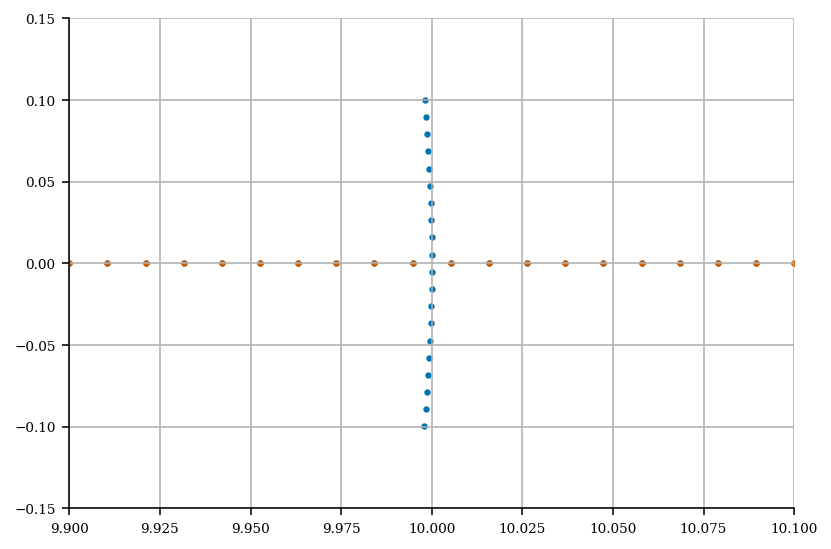

In [7]:
plt.scatter(rs.flatten(), zs.flatten(), s=5)
plt.scatter(r0.flatten(), z0.flatten(), s=5)
plt.ylim(-.15,.15)
plt.xlim(9.9,10.1)
plt.grid(True)

In [2]:
from desc.nestor import Nestor
from desc.magnetic_fields import SplineMagneticField
from desc.vmec_utils import ptolemy_identity_fwd
from desc.utils import copy_coeffs
from desc.profiles import SplineProfile

def nestor_to_eq(vacin):

    ntor    = int(vacin['ntor'][()])
    mpol    = int(vacin['mpol'][()])
    nzeta   = int(vacin['nzeta'][()])
    ntheta  = int(vacin['ntheta'][()])
    NFP     = int(vacin['nfp'][()])
    sym     = bool(vacin['lasym__logical__'][()] == 0)

    raxis   = vacin['raxis_nestor'][()]
    zaxis   = vacin['zaxis_nestor'][()]
    wint    = np.array(vacin['wint'][()])

    xm      = vacin['xm'][()]
    xn      = vacin['xn'][()]
    rmnc    = vacin['rmnc'][()]
    zmns    = vacin['zmns'][()]

    bdry_grid = LinearGrid(rho=1, M=ntheta, N=nzeta, NFP=NFP)
    mr, nr, Rb_mn = ptolemy_identity_fwd(xm, xn//NFP, np.zeros_like(rmnc), rmnc)
    mz, nz, Zb_mn = ptolemy_identity_fwd(xm, xn//NFP, zmns, np.zeros_like(zmns))
    M = max(np.max(abs(mr)),np.max(abs(mz)))
    N = max(np.max(abs(nr)),np.max(abs(nz)))        
    Rb_mn = Rb_mn[0]
    Zb_mn = Zb_mn[0]
    modes_Rb = np.array([np.zeros_like(mr), mr, nr]).T
    modes_Zb = np.array([np.zeros_like(mz), mz, nz]).T
        
    a_basis = FourierSeries(N=N, NFP=NFP, sym=False)
    axis_grid = LinearGrid(rho=0, theta=0, N=nzeta, NFP=NFP)
    a_transform = Transform(axis_grid, a_basis)
    Ra_n = a_transform.fit(raxis)
    Za_n = a_transform.fit(zaxis)


    temp_basis = DoubleFourierSeries(M=M, N=N, NFP=NFP, sym=False)
    Rb_lmn = copy_coeffs(Rb_mn, modes_Rb, temp_basis.modes).reshape((-1,1))
    Zb_lmn = copy_coeffs(Zb_mn, modes_Zb, temp_basis.modes).reshape((-1,1))
    boundary = np.hstack([temp_basis.modes, Rb_lmn, Zb_lmn])
    axis = np.hstack([a_basis.modes[:,2:], Ra_n[:,np.newaxis], Za_n[:,np.newaxis]])
    profiles = np.array([0,0,0]).reshape((1,3))
    eq = {"L": 2*M,
          "M": M,
          "N": N,
          "profiles": profiles,
          "boundary": boundary,
          "NFP": NFP,
          "Psi": 1.0,
          "axis": axis,
          "sym": sym,
          "node_pattern": "jacobi"
    }
    eq = Equilibrium(eq)
    return eq
    
vacin = Dataset("../tests/inputs/nestor/ref_in/vacin_test.vmec_000000.nc","r")
mgrid = "../tests/inputs/nestor/mgrid_test.nc"
ntor    = int(vacin['ntor'][()])
mpol    = int(vacin['mpol'][()])
nzeta   = int(vacin['nzeta'][()])
ntheta  = int(vacin['ntheta'][()])
NFP     = int(vacin['nfp'][()])
sym     = bool(vacin['lasym__logical__'][()] == 0)

rbtor   = vacin['rbtor'][()][()]
ctor    = vacin['ctor'][()][()]
signgs  = vacin['signgs'][()][()]

extcur = vacin['extcur'][()]        
folder = os.getcwd()
mgridFilename = os.path.join(folder, mgrid)
ext_field = SplineMagneticField.from_mgrid(mgridFilename, extcur, extrap=True, period=(2*np.pi/NFP))

mf = mpol+1
nf = ntor


ir = InputReader("/home/fouriest/SCHOOL/Princeton/PPPL/educational_VMEC/test/input.test_vac.vmec_desc")
eq = Equilibrium(**ir.inputs[0])
eq.change_resolution(M=4, N=4, L=8, L_grid=12, M_grid=6, N_grid=6)
eq.x0 = eq.x

veq = VMECIO.load("../../educational_VMEC/test/wout_test_vac.vmec.nc", spectral_indexing="fringe")
veq.change_resolution(eq.L, eq.M, eq.N)

f = Dataset("../../educational_VMEC/test/wout_test_vac.vmec.nc")
pres = np.asarray(f.variables['presf'])
sp = np.linspace(0,1,pres.size)
rp = np.sqrt(sp)
# pres[0] = pres[1]
pressure = SplineProfile(pres, rp)

iot = np.asarray(f.variables['iotaf'])
si = np.linspace(0,1,iot.size)
ri = np.sqrt(si)
iota = SplineProfile(iot, ri)

eq.NFP = int(eq.NFP)
eq.Psi = veq.Psi
eq.pressure = pressure
eq.iota = iota
veq.pressure = pressure
veq.iota = iota

eq.objective="force"
eq.optimizer = "scipy-trf"

mf = eq.M+1
nf = eq.N
ntheta = 4*eq.M+6
nzeta = 4*eq.N+6
nest = Nestor(eq, ext_field, mf, nf, ntheta, nzeta, )

In [ ]:
vacin = Dataset("../tests/inputs/nestor/ref_in/vacin_test.vmec_000000.nc","r")
mgrid = "../tests/inputs/nestor/mgrid_test.nc"
ntor    = int(vacin['ntor'][()])
mpol    = int(vacin['mpol'][()])
nzeta   = int(vacin['nzeta'][()])
ntheta  = int(vacin['ntheta'][()])
NFP     = int(vacin['nfp'][()])
sym     = bool(vacin['lasym__logical__'][()] == 0)

rbtor   = vacin['rbtor'][()][()]
ctor    = vacin['ctor'][()][()]
signgs  = vacin['signgs'][()][()]

extcur = vacin['extcur'][()]        


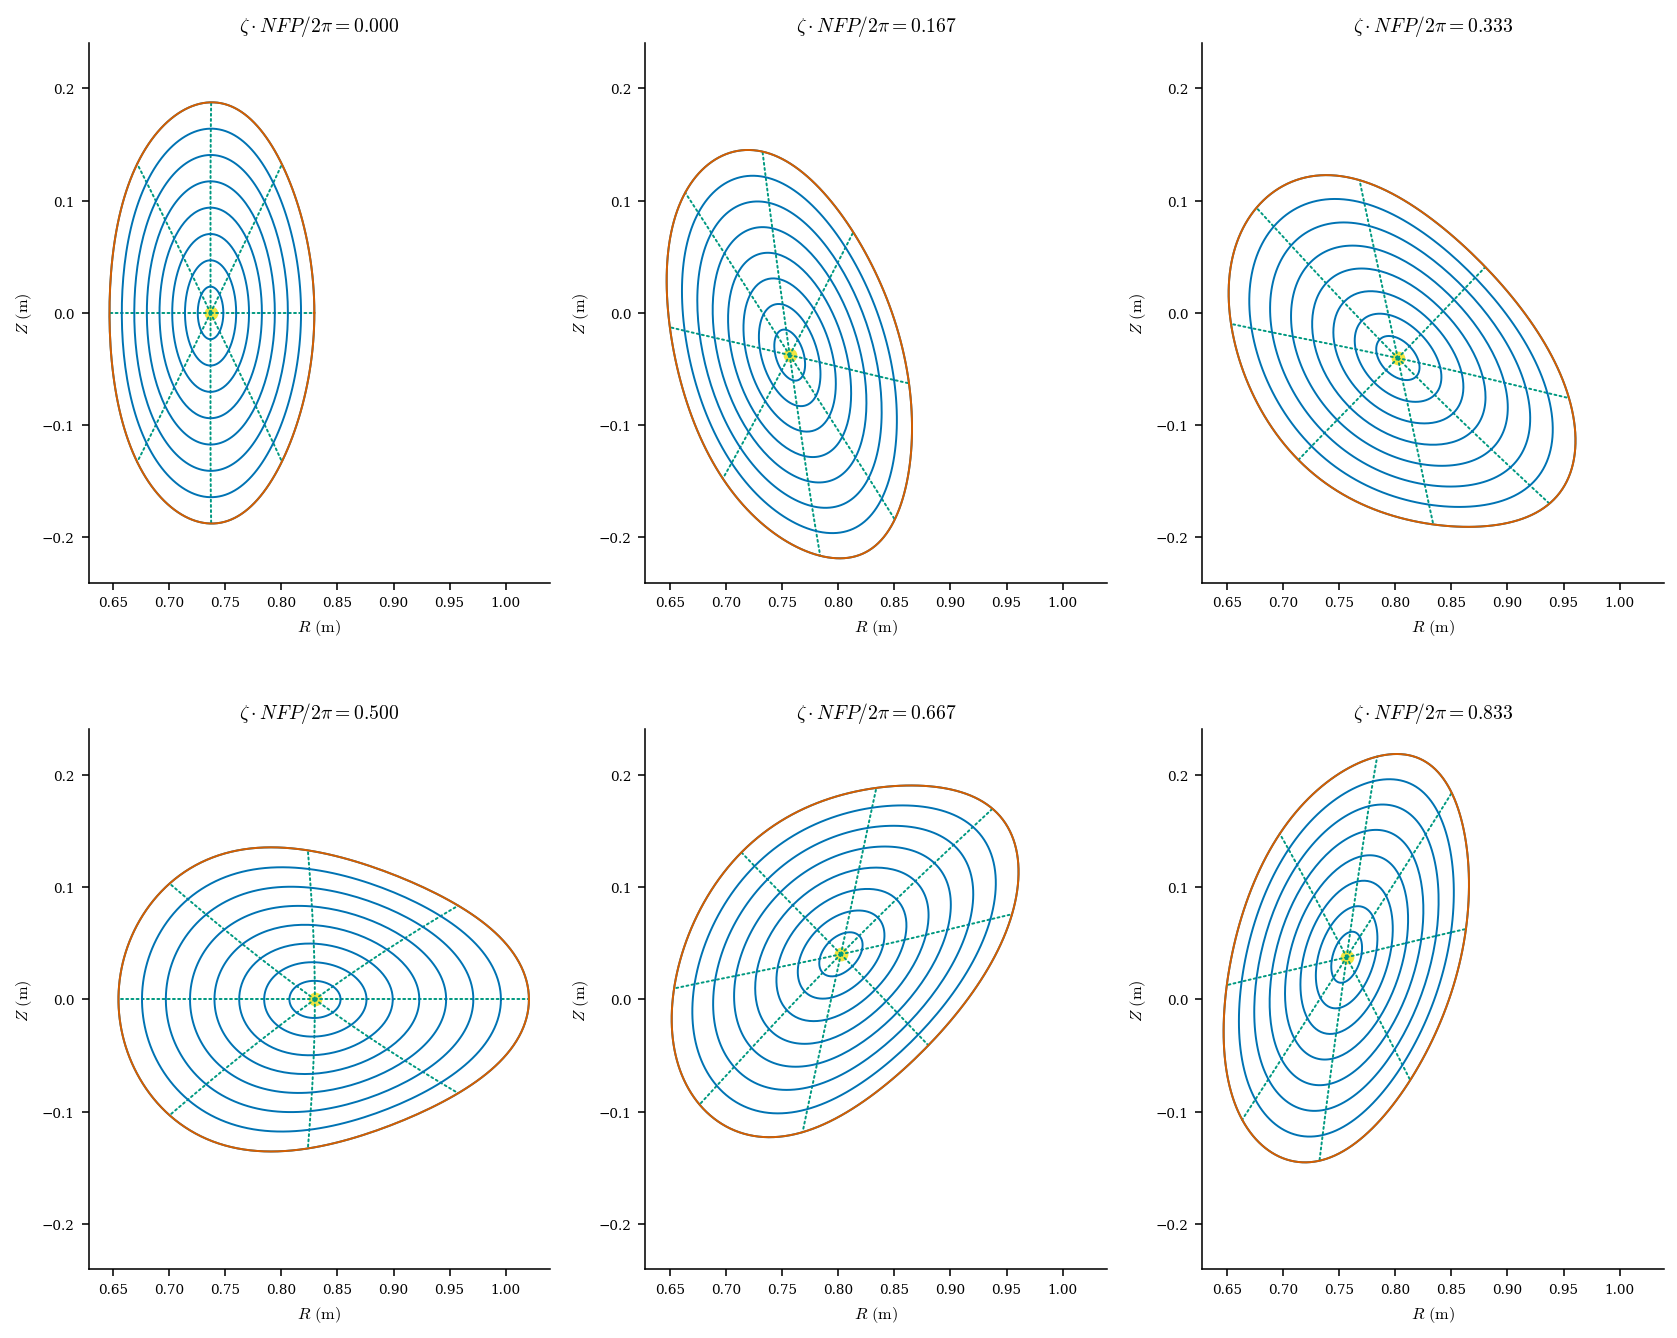

In [7]:
plot_surfaces(eq);

In [25]:
eq.solve();

Precomputing transforms
Compiling objective function and derivatives
Starting optimization
`ftol` termination condition is satisfied.
Function evaluations 10, initial cost 8.3214e+07, final cost 1.4437e+02, first-order optimality 2.56e+03.
Start of solver
Total residual:  8.321e+07  f_rho:  9.502e+03  f_beta:  8.726e+03
End of solver
Total residual:  1.444e+02  f_rho:  1.073e+01  f_beta:  1.317e+01


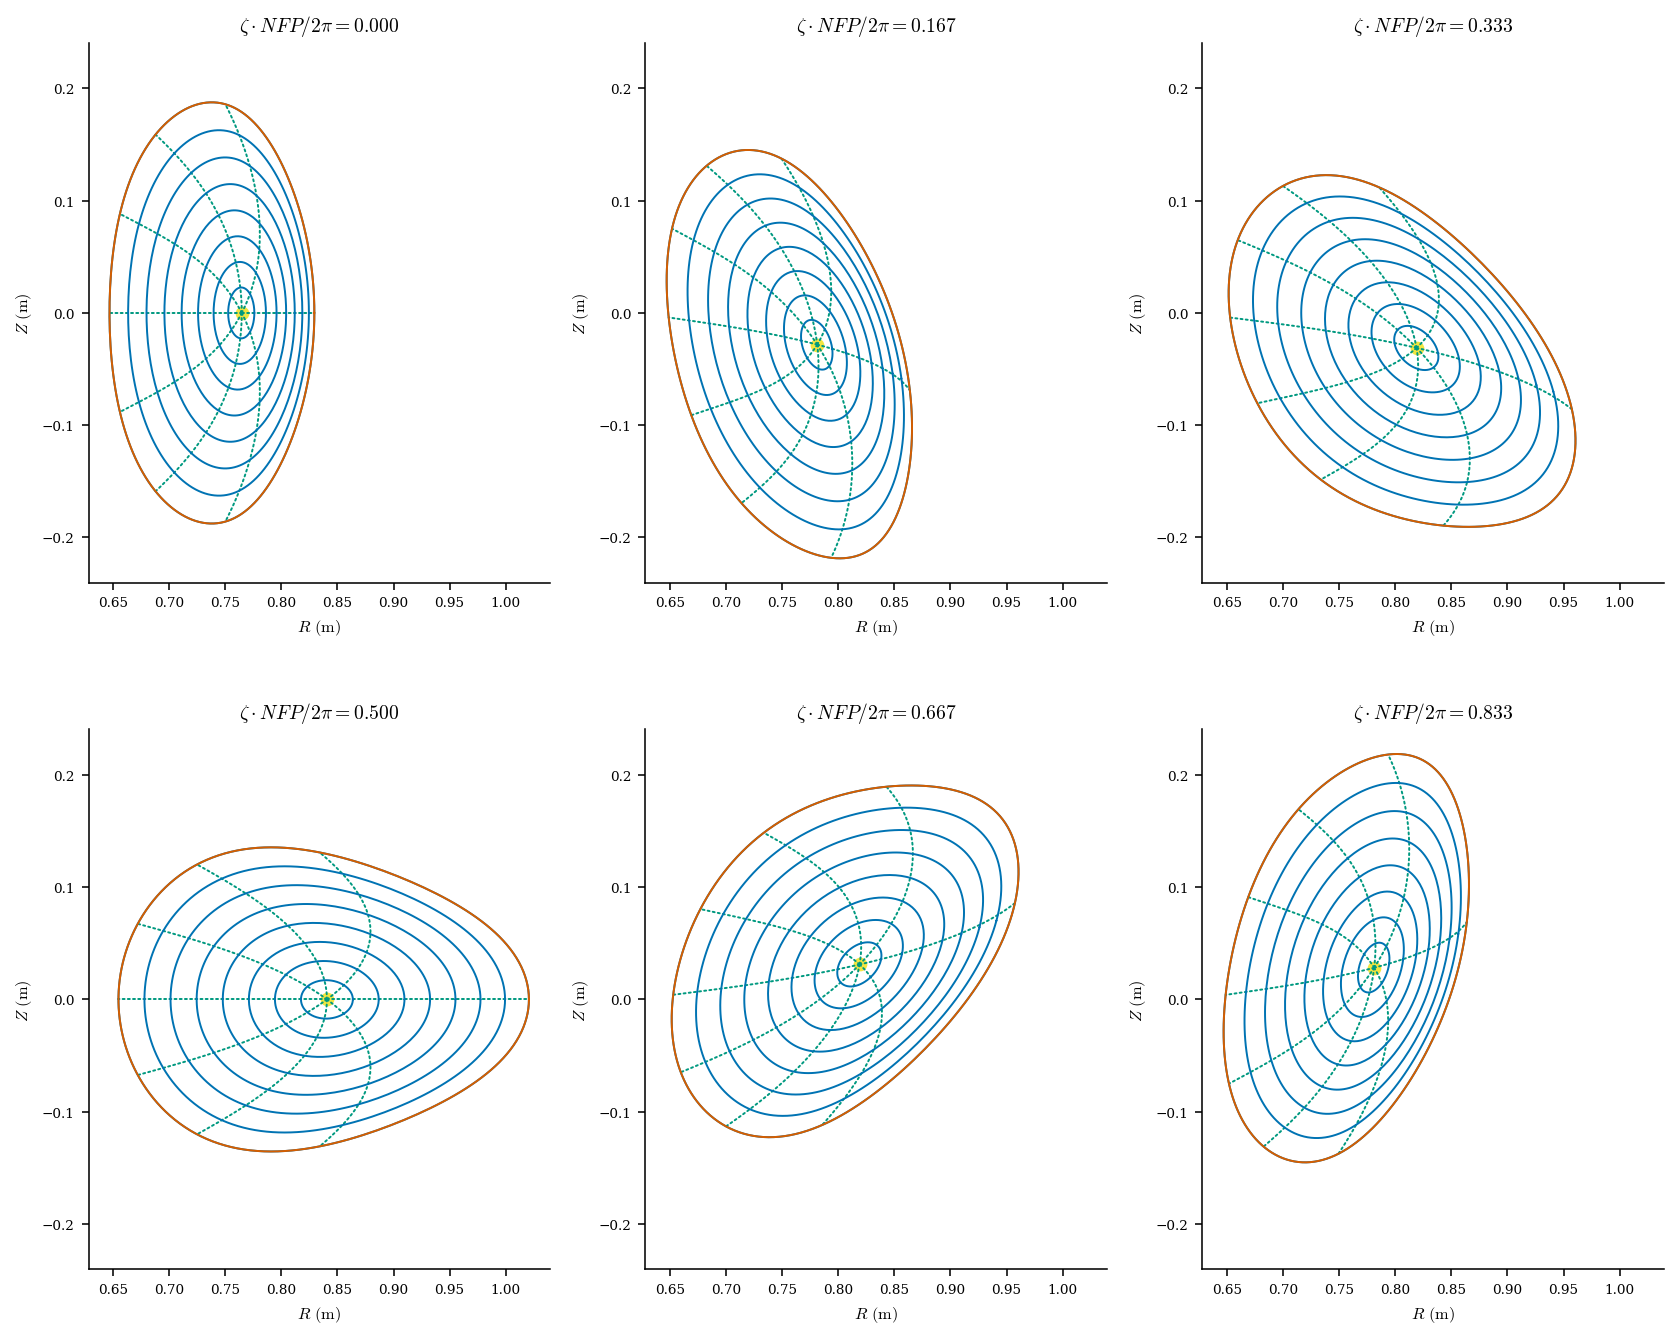

In [26]:
plot_surfaces(eq);

In [12]:
from desc.utils import unpack_state
from desc.compute_funs import compute_current_density, compute_magnetic_field_magnitude, compute_magnetic_field, dot

Jgrid = QuadratureGrid(L=4*eq.L,M=4*eq.M, N=eq.N, NFP=eq.NFP)
# Jgrid.nodes[:,2] = 0
JR_transform = Transform(Jgrid, eq.R_basis, derivs=2)
JZ_transform = Transform(Jgrid, eq.Z_basis, derivs=2)
JL_transform = Transform(Jgrid, eq.L_basis, derivs=2)
Bgrid = LinearGrid(M=ntheta,N=nzeta, rho=1, sym=nest.sym, NFP=eq.NFP) 
BR_transform = Transform(Bgrid, eq.R_basis, derivs=1)
BZ_transform = Transform(Bgrid, eq.Z_basis, derivs=1)
BL_transform = Transform(Bgrid, eq.L_basis, derivs=1)

B1grid = LinearGrid(M=ntheta,N=nzeta, rho=1, sym=nest.sym, NFP=eq.NFP) 
B1R_transform = Transform(Bgrid, eq.R_basis, derivs=1)
B1Z_transform = Transform(Bgrid, eq.Z_basis, derivs=1)
B1L_transform = Transform(Bgrid, eq.L_basis, derivs=1)


Jp_profile = eq.pressure.copy()
Ji_profile = eq.iota.copy()
Bp_profile = eq.pressure.copy()
Bi_profile = eq.iota.copy()
B1p_profile = eq.pressure.copy()
B1i_profile = eq.iota.copy()
Jp_profile.grid = Jgrid
Ji_profile.grid = Jgrid
Bp_profile.grid = Bgrid
Bi_profile.grid = Bgrid
B1p_profile.grid = Bgrid
B1i_profile.grid = Bgrid

def compute_I(Psi, R_lmn, Z_lmn, L_lmn, p_l, i_l, R_transform, Z_transform, L_transform, p_profile, i_profile):
    out = compute_magnetic_field(Psi, R_lmn, Z_lmn, L_lmn, p_l, i_l, R_transform, Z_transform, L_transform, p_profile, i_profile)
    B = out[0]
    w = R_transform.grid.weights
    return jnp.sum(B['B_theta']*w)/(mu_0*2*np.pi)

def bsq_vac(Psi, R_lmn, Z_lmn, L_lmn, p_l, i_l, R_transform, Z_transform, L_transform, p_profile, i_profile, nest):
    
    ctor = compute_I(Psi, R_lmn, Z_lmn, L_lmn, p_l, i_l, R_transform, Z_transform, L_transform, p_profile, i_profile)
    out = nest.compute(R_lmn, Z_lmn, ctor)
    bsq = out[1]['|B|^2']

    return (bsq/mu_0).flatten()

def bsq_plasma(Psi, R_lmn, Z_lmn, L_lmn, p_l, i_l, R_transform, Z_transform, L_transform, p_profile, i_profile):
    
    out = compute_magnetic_field_magnitude(Psi, R_lmn, Z_lmn, L_lmn, p_l, i_l, R_transform, Z_transform, L_transform, p_profile, i_profile)
    bsq = out[0]['|B|']**2
    g = out[1]['g_rad']
    return (bsq*g/2/mu_0).reshape((Bgrid.M,-1)).T.flatten()

def freeb_objective(x, Psi, p_l, i_l):
    R_lmn, Z_lmn, L_lmn = unpack_state(x, eq.R_basis.num_modes, eq.Z_basis.num_modes)
    bv = bsq_vac(Psi, R_lmn, Z_lmn, L_lmn, p_l, i_l, B1R_transform, B1Z_transform, B1L_transform, B1p_profile, B1i_profile, nest)
    bp = bsq_plasma(Psi, R_lmn, Z_lmn, L_lmn, p_l, i_l, BR_transform, BZ_transform, BL_transform, Bp_profile, Bi_profile)
    return bv-bp - Bp_profile([1.0])

freeb_objective = jit(freeb_objective)
freeb_jac = jax.jit(jax.jacfwd(freeb_objective))

In [9]:
Jgrid = QuadratureGrid(L=eq.L,M=eq.M, N=int(eq.N*eq.NFP), NFP=1)
JR_transform = Transform(Jgrid, eq.R_basis, derivs=2)
JZ_transform = Transform(Jgrid, eq.Z_basis, derivs=2)
JL_transform = Transform(Jgrid, eq.L_basis, derivs=2)
Jp_profile = eq.pressure.copy()
Ji_profile = eq.iota.copy()
Jp_profile.grid = Jgrid
Ji_profile.grid = Jgrid

Bgrid = LinearGrid(M=ntheta,N=nzeta, rho=1, sym=nest.sym, NFP=eq.NFP) 
BR_transform = Transform(Bgrid, eq.R_basis, derivs=1)
BZ_transform = Transform(Bgrid, eq.Z_basis, derivs=1)
BL_transform = Transform(Bgrid, eq.L_basis, derivs=1)



@jax.jit
def biot_savart(reval,rsource,Jsource):
    rr = reval[:,np.newaxis] - rsource[np.newaxis]
    a = jnp.cross(Jsource,rr)
    b = jnp.linalg.norm(rr, axis=-1)
    mask = abs(b)<1e-12
    b = b*b*b
    binv = jnp.where(mask, 0, 1/b)
    B = mu_0 / (4*np.pi)*jnp.sum(a*binv[:,:,np.newaxis], axis=1)
    return B

def bsq_diff(R_lmn, Z_lmn, L_lmn, p_l, i_l, Psi):

    
    out = compute_magnetic_field_magnitude(Psi, R_lmn, Z_lmn, L_lmn, p_l, i_l, BR_transform, BZ_transform, BL_transform, Bp_profile, Bi_profile)
    bdry_field, bdry_jac, _, bdry_coords, bdry_profiles = out
    reval = jnp.array([bdry_coords["R"], BR_transform.grid.nodes[:,2], bdry_coords["Z"]]).T
    bsq_in = bdry_field['|B|']**2
    bdry_g = bdry_jac['g_rad']
    bdry_w = BR_transform.grid.weights
    
    bcoil_ext = ext_field.compute_magnetic_field(reval)
    
    R_n   =  (bdry_coords["R"] * bdry_coords["Z_t"])
    phi_n =  (bdry_coords["R_t"] * bdry_coords["Z_z"] - bdry_coords["R_z"] * bdry_coords["Z_t"])
    Z_n   = -(bdry_coords["R"] * bdry_coords["R_t"])
    normal = jnp.array([R_n,phi_n,Z_n]).T
    
    out = compute_current_density(Psi, R_lmn, Z_lmn, L_lmn, p_l, i_l, JR_transform, JZ_transform, JL_transform, Jp_profile, Ji_profile)
    cur, _, vol_jac, cov, vol_coords, _ = out
    rsource = jnp.array([vol_coords["R"], JR_transform.grid.nodes[:,2], vol_coords["Z"]]).T
    Jsource = cur['J^rho']*cov['e_rho'] + cur['J^theta']*cov['e_theta'] + cur['J^zeta']*cov['e_zeta']
    vol_g = vol_jac['g']
    vol_w = JR_transform.grid.weights

    bplasma_ext = biot_savart(reval, rsource, (Jsource*vol_g*vol_w).T)
    bext = bcoil_ext + bplasma_ext
    B_n = jnp.sum(bext*normal, axis=-1)
    bsq_out = jnp.sum(bext**2, axis=-1)
    pres = Bp_profile.compute(p_l)
    
    return bsq_out, bsq_in, pres, B_n, bdry_g, bdry_w
    
    

In [10]:
bsq_out, bsq_in, pres, B_n, bdry_g, bdry_w = bsq_diff(eq.R_lmn, eq.Z_lmn, eq.L_lmn, eq.p_l, eq.i_l, eq.Psi)

In [13]:
eqvac = bsq_vac(eq.Psi, eq.R_lmn, eq.Z_lmn, eq.L_lmn, eq.p_l, eq.i_l, B1R_transform, B1Z_transform, B1L_transform, B1p_profile, B1i_profile, nest)
eqpls = bsq_plasma(eq.Psi, eq.R_lmn, eq.Z_lmn, eq.L_lmn, eq.p_l, eq.i_l, BR_transform, BZ_transform, BL_transform, Bp_profile, Bi_profile)

veqvac = bsq_vac(veq.Psi, veq.R_lmn, veq.Z_lmn, veq.L_lmn, veq.p_l, veq.i_l, B1R_transform, B1Z_transform, B1L_transform, B1p_profile, B1i_profile, nest)
veqpls = bsq_plasma(veq.Psi, veq.R_lmn, veq.Z_lmn, veq.L_lmn, veq.p_l, veq.i_l, BR_transform, BZ_transform, BL_transform, Bp_profile, Bi_profile)

In [8]:
22*19

418

In [13]:
432/36

12.0

In [ ]:
eqpls.shape

In [ ]:
B1R_transform.num_nodes

In [ ]:
BR_transform.num_nodes

In [45]:
def objfun(x):
    return eq.objective.compute_scalar(x, eq.Rb_lmn, eq.Zb_lmn, eq.p_l, eq.i_l, eq.Psi)

def objgrad(x):
    return eq.objective.grad_x(x, eq.Rb_lmn, eq.Zb_lmn, eq.p_l, eq.i_l, eq.Psi)

def objhess(x):
    J = eq.objective.jac_x(x, eq.Rb_lmn, eq.Zb_lmn, eq.p_l, eq.i_l, eq.Psi)
    return J.T@J

def confun(x):
    R_lmn, Z_lmn, L_lmn = unpack_state(x, eq.R_basis.num_modes, eq.Z_basis.num_modes)
    bsq_out, bsq_in, pres, B_n, bdry_g, bdry_w = bsq_diff(R_lmn, Z_lmn, L_lmn, eq.p_l, eq.i_l, eq.Psi)
    B_n = B_n * bdry_g * bdry_w
    bdiff = bsq_in + pres - bsq_out
    return jnp.array([B_n, bdiff]).flatten()
    
conjac = jax.jacfwd(confun)



In [34]:
eq.x = out['x']

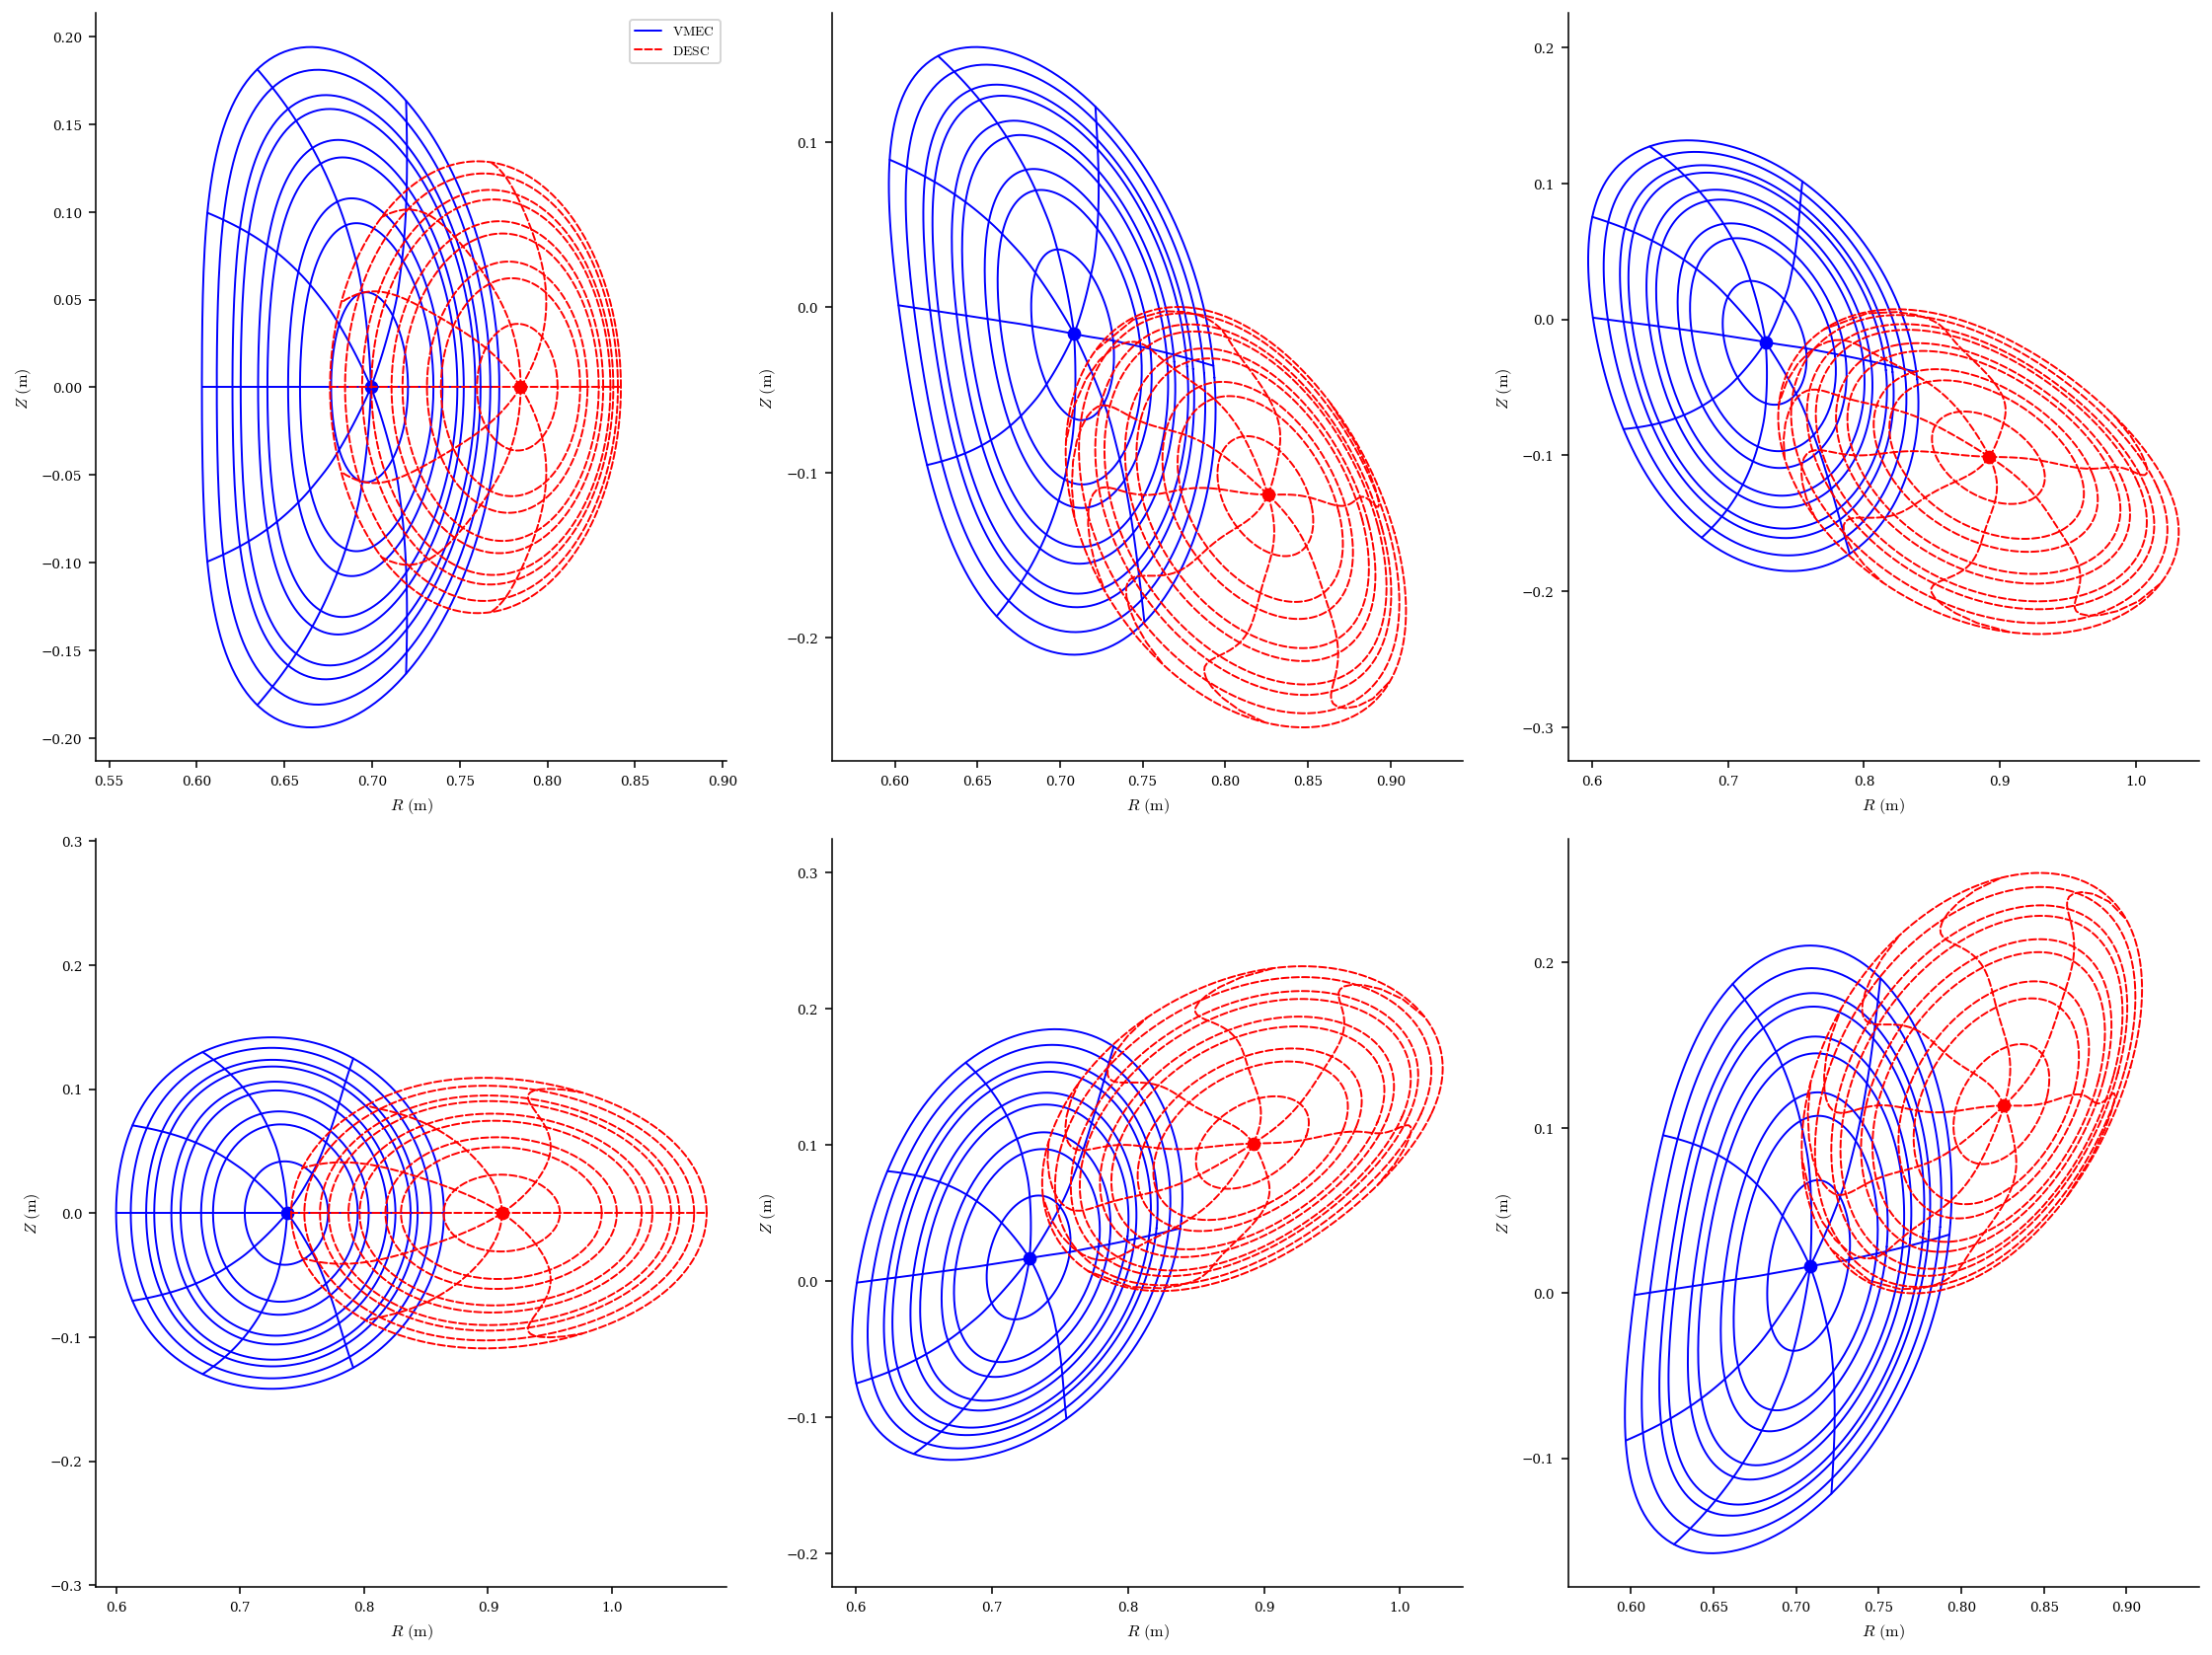

In [20]:
fig, ax = VMECIO.plot_vmec_comparison(eq, "../../educational_VMEC/test/wout_test_vac.vmec.nc")

In [17]:
eq.solve()

Precomputing transforms
Compiling objective function and derivatives
Starting optimization
`ftol` termination condition is satisfied.
Function evaluations 10, initial cost 8.3214e+07, final cost 1.4437e+02, first-order optimality 2.56e+03.
Start of solver
Total residual:  8.321e+07  f_rho:  9.502e+03  f_beta:  8.726e+03
End of solver
Total residual:  1.444e+02  f_rho:  1.073e+01  f_beta:  1.317e+01


       allx: [array([ 7.71742892e-04, -3.61472021e-04,  1.06631292e-03, -5.02835603e-03,
        1.43628060e-04, -6.91477152e-05,  1.06631292e-03, -4.73272388e-03,
       -1.09955658e-03,  1.43628060e-04,  1.73055761e-05,  1.06631292e-03,
       -4.73272388e-03,  1.43628060e-04,  1.06631292e-03,  8.41264558e-05,
       -4.13955291e-03,  3.53635653e-05, -6.18506785e-04, -4.19881671e-03,
       -5.90965400e-03,  3.53635653e-05, -6.42990537e-04, -6.24701980e-01,
       -4.19881671e-03, -5.92448723e-03,  3.53635653e-05, -6.42990537e-04,
       -4.19881671e-03,  3.53635653e-05, -4.40361290e-02,  7.81349672e-02,
       -4.40702814e-02, -5.01205688e-04,  7.80912310e-02,  2.32762992e-02,
       -4.40702814e-02, -5.35713844e-04,  1.20747888e-04,  7.80912310e-02,
        2.32610489e-02, -4.40702814e-02, -5.35713844e-04,  7.80912310e-02,
       -4.40702814e-02,  6.97686229e-02,  3.43611485e-05,  6.98787194e-02,
        1.83027387e-03,  3.64373189e-04,  2.32314094e-02,  6.98787194e-02,
        2.1

In [14]:
def objective(x, freeb_weight):
    
    force = eq.objective.compute(x, eq.Rb_lmn, eq.Zb_lmn, eq.p_l, eq.i_l, eq.Psi)
    bsq = freeb_objective(x, eq.Psi, eq.p_l, eq.i_l)
    
    return jnp.concatenate([force, freeb_weight*bsq])

def objective_jac(x, freeb_weight):
    
    force = eq.objective.jac_x(x, eq.Rb_lmn, eq.Zb_lmn, eq.p_l, eq.i_l, eq.Psi)
    bsq = freeb_jac(x, eq.Psi, eq.p_l, eq.i_l)
    
    return jnp.vstack([force, freeb_weight*bsq])
    

In [18]:
freeb_weight = 1e10
eq.build()
out = scipy.optimize.least_squares(objective, eq.x, jac=objective_jac, ftol=1e-2, x_scale="jac", max_nfev=100, verbose=2, args=(freeb_weight,))

Precomputing Transforms
Factorizing boundary constraint
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.3084e+32                                    2.56e+34    
       1              6         2.1177e+32      1.91e+31       1.51e-02       4.28e+34    
       2              7         1.8488e+32      2.69e+31       2.88e-02       2.02e+34    
       3              8         1.6536e+32      1.95e+31       8.49e-02       3.15e+34    
       4              9         1.3292e+32      3.24e+31       3.64e-02       1.80e+34    
       5             10         8.7244e+31      4.57e+31       8.86e-02       3.89e+34    
       6             11         4.2796e+31      4.44e+31       1.22e-01       1.27e+35    
       7             13         2.7323e+31      1.55e+31       1.06e-01       1.71e+35    
       8             14         8.7846e+30      1.85e+31       1.46e-01       2.20e+35    
       9             15         3.

- try different initial guesses
- try fixed bdry iterations first
- try oversampling bdry nodes

In [19]:
eq.x = out['x']

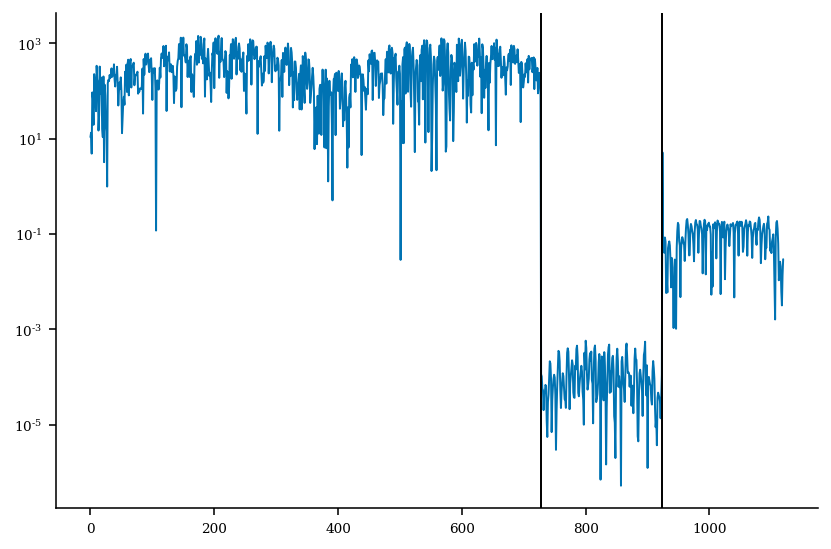

In [145]:
f0 = objective(eq.x0, 1)
plt.semilogy(abs(f0))
plt.axvline(2*eq.objective.R_transform.num_nodes, c='k')
plt.axvline(2*eq.objective.R_transform.num_nodes + Bgrid.num_nodes, c='k')

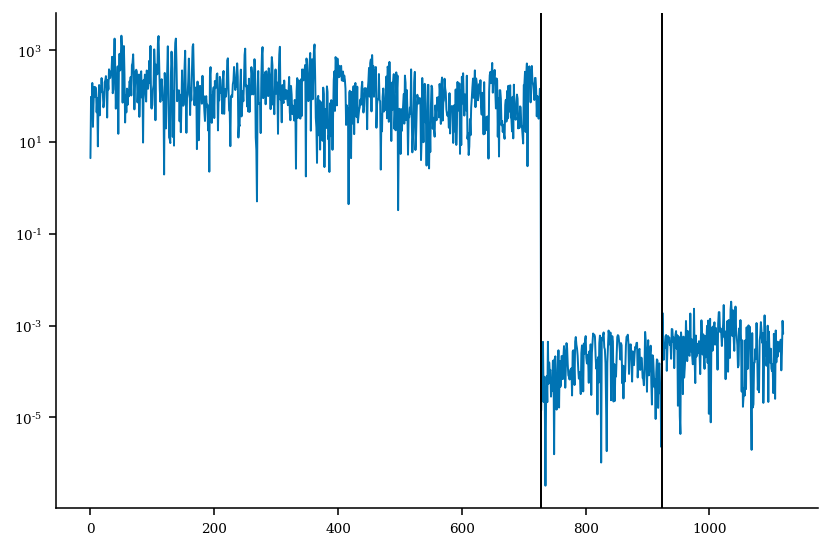

In [146]:
f1 = objective(eq.x, 1)
plt.semilogy(abs(f1))
plt.axvline(2*eq.objective.R_transform.num_nodes, c='k')
plt.axvline(2*eq.objective.R_transform.num_nodes + Bgrid.num_nodes, c='k')

(<Figure size 2256x1692 with 6 Axes>,
 array([<AxesSubplot:xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <AxesSubplot:xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <AxesSubplot:xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <AxesSubplot:xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <AxesSubplot:xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <AxesSubplot:xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>],
       dtype=object))

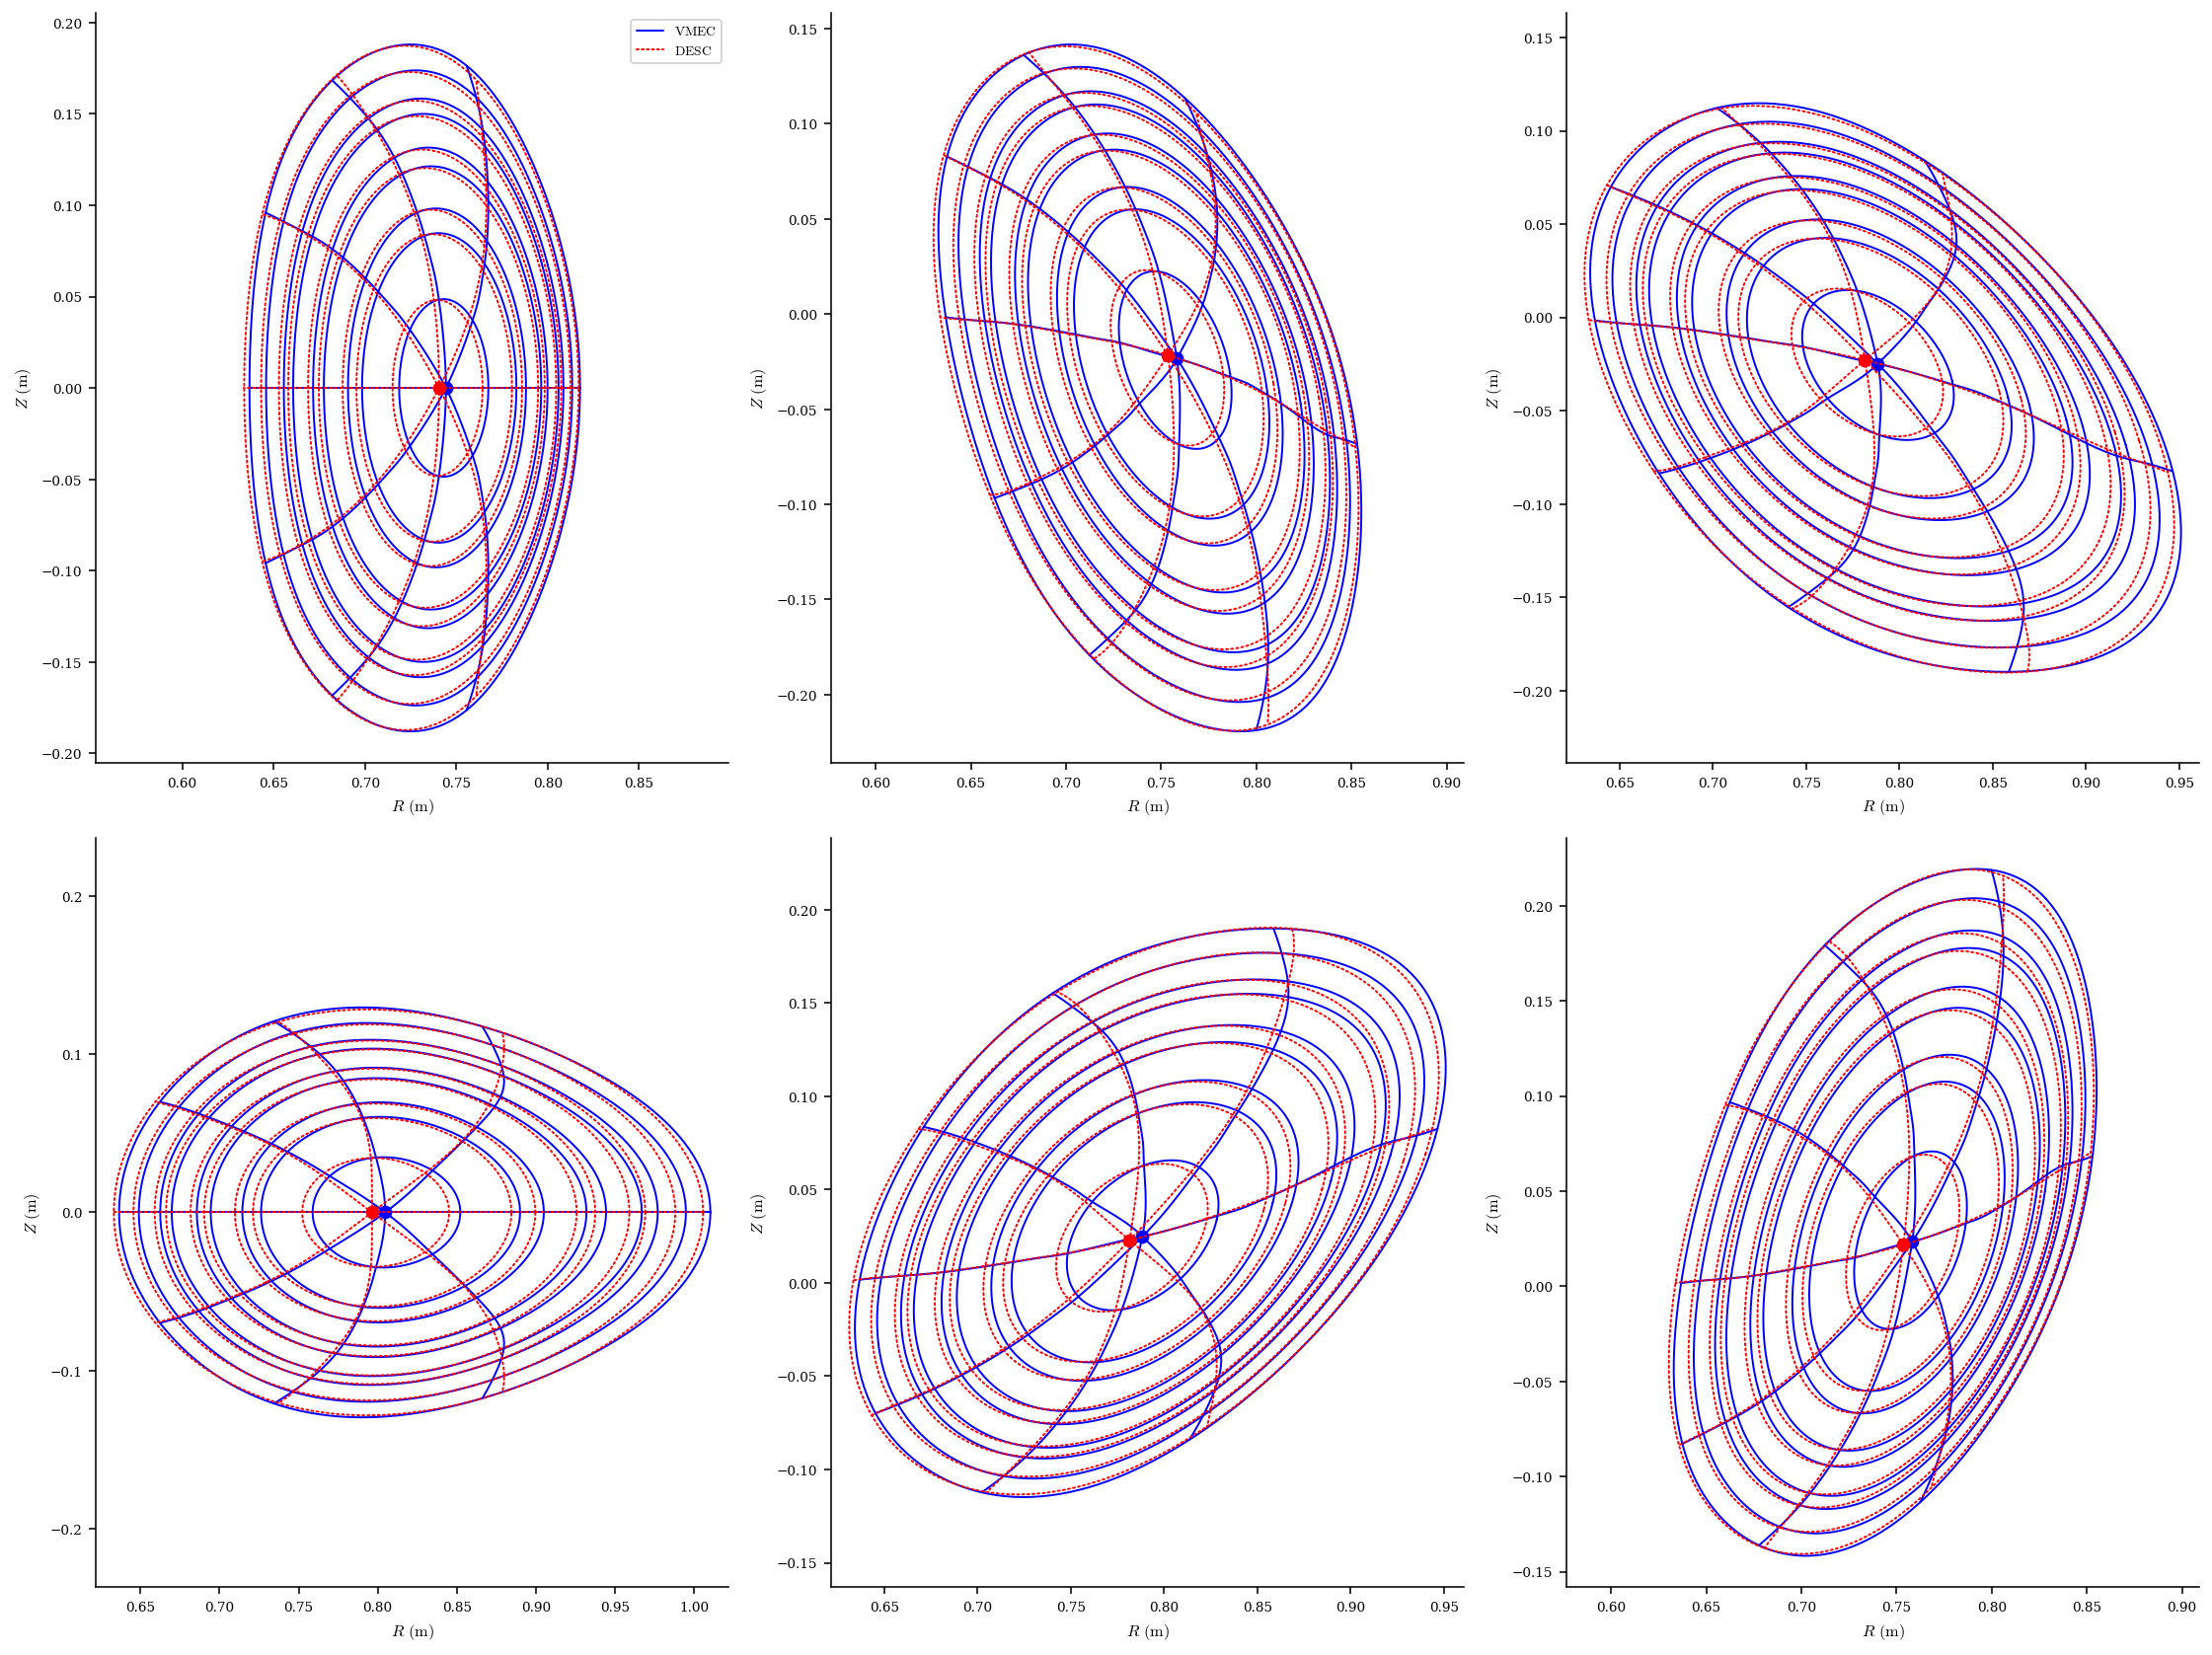

In [87]:
VMECIO.plot_vmec_comparison(veq, "../../educational_VMEC/test/wout_test.vmec.nc")

(-0.25, 0.25)

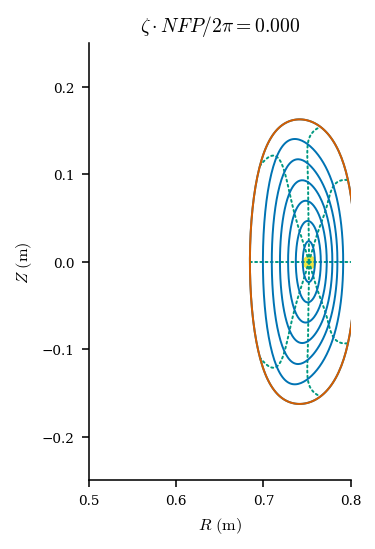

In [149]:
fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"))
ax.scatter(rs.flatten(),zs.flatten(), s=0.1)
fig, ax = plot_surfaces(eq, nzeta=1, ax=ax)
ax[0].set_xlim(0.5, 0.8)
ax[0].set_ylim(-.25,.25)

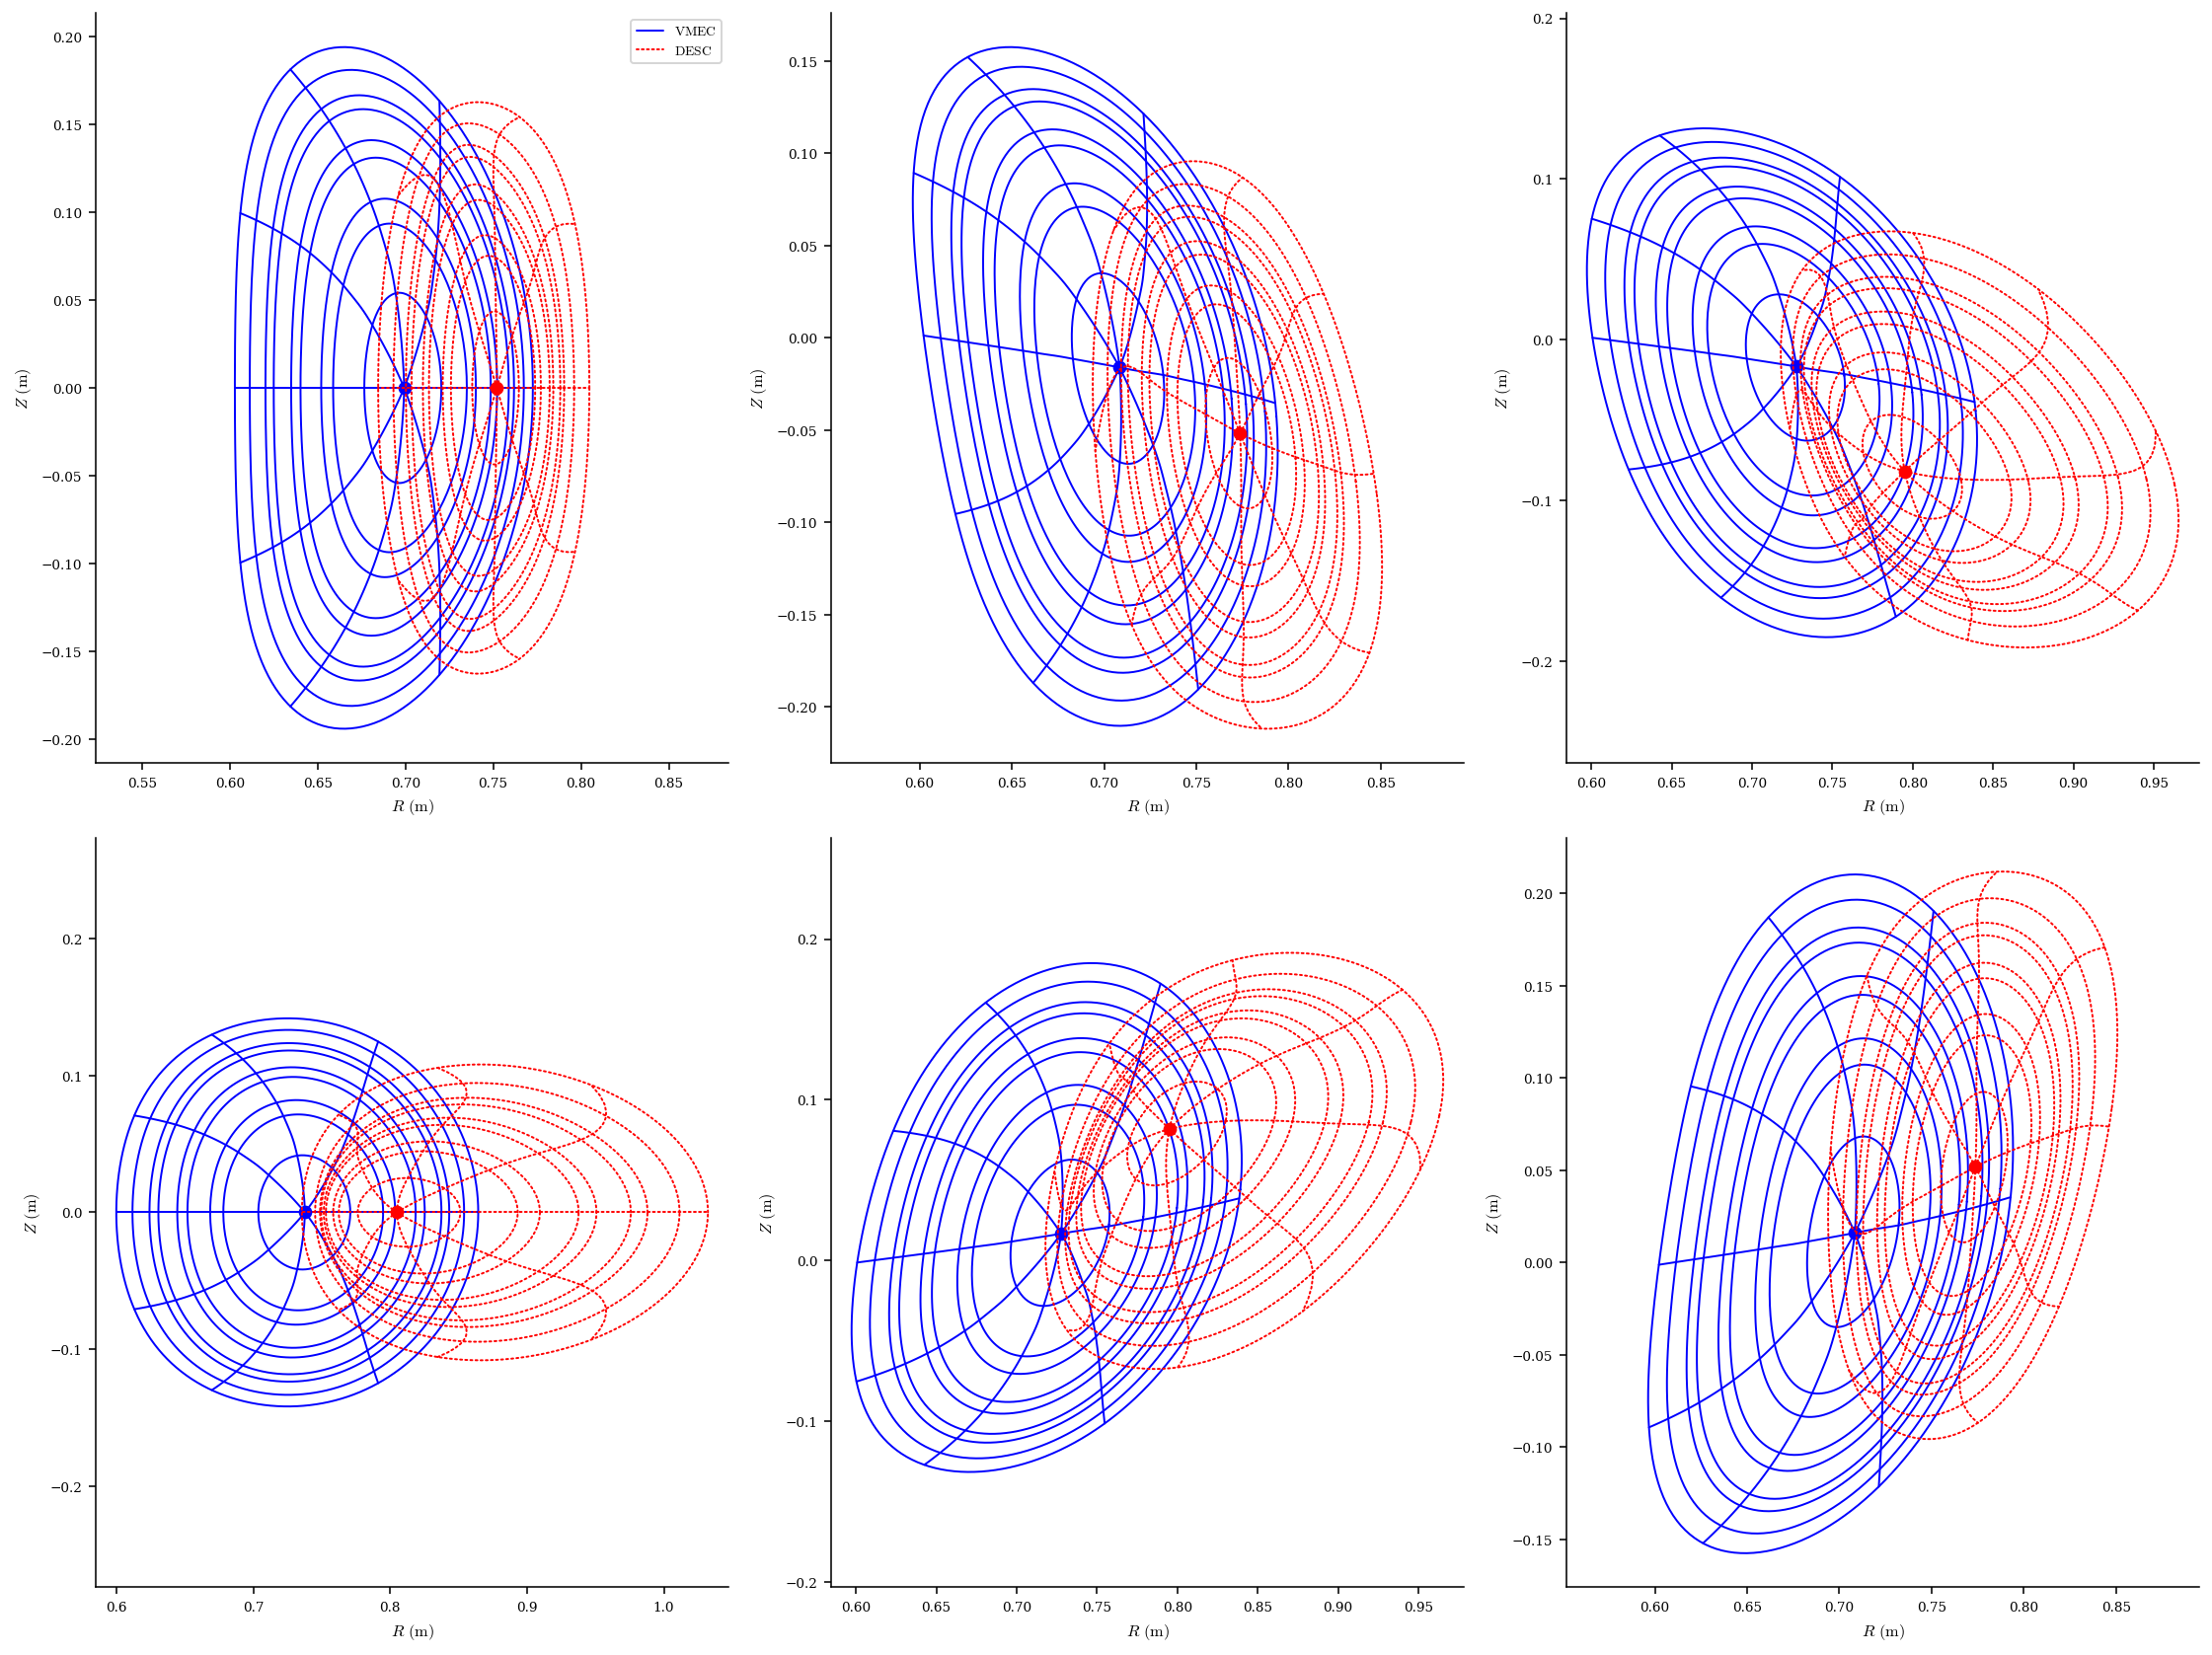

In [152]:
fig, ax = VMECIO.plot_vmec_comparison(eq, "../../educational_VMEC/test/wout_test_vac.vmec.nc")
# ax[0].scatter(rs.flatten(),zs.flatten(), s=0.1)
# ax[0].set_xlim(0.6,0.95)
# ax[0].set_ylim(-.25,.25)

(<Figure size 2115x1410 with 12 Axes>,
 array([<AxesSubplot:title={'center':'|F| / |$|\\nabla(p)|~$| $\\zeta \\cdot NFP/2\\pi = 0.000$ '}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <AxesSubplot:title={'center':'|F| / |$|\\nabla(p)|~$| $\\zeta \\cdot NFP/2\\pi = 0.167$ '}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <AxesSubplot:title={'center':'|F| / |$|\\nabla(p)|~$| $\\zeta \\cdot NFP/2\\pi = 0.333$ '}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <AxesSubplot:title={'center':'|F| / |$|\\nabla(p)|~$| $\\zeta \\cdot NFP/2\\pi = 0.500$ '}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <AxesSubplot:title={'center':'|F| / |$|\\nabla(p)|~$| $\\zeta \\cdot NFP/2\\pi = 0.667$ '}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <AxesSubplot:title={'center':'|F| / |$|\\nabla(p)|~$| $\\zeta \\cdot NFP/2\\pi = 0.833$ '}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>],
      

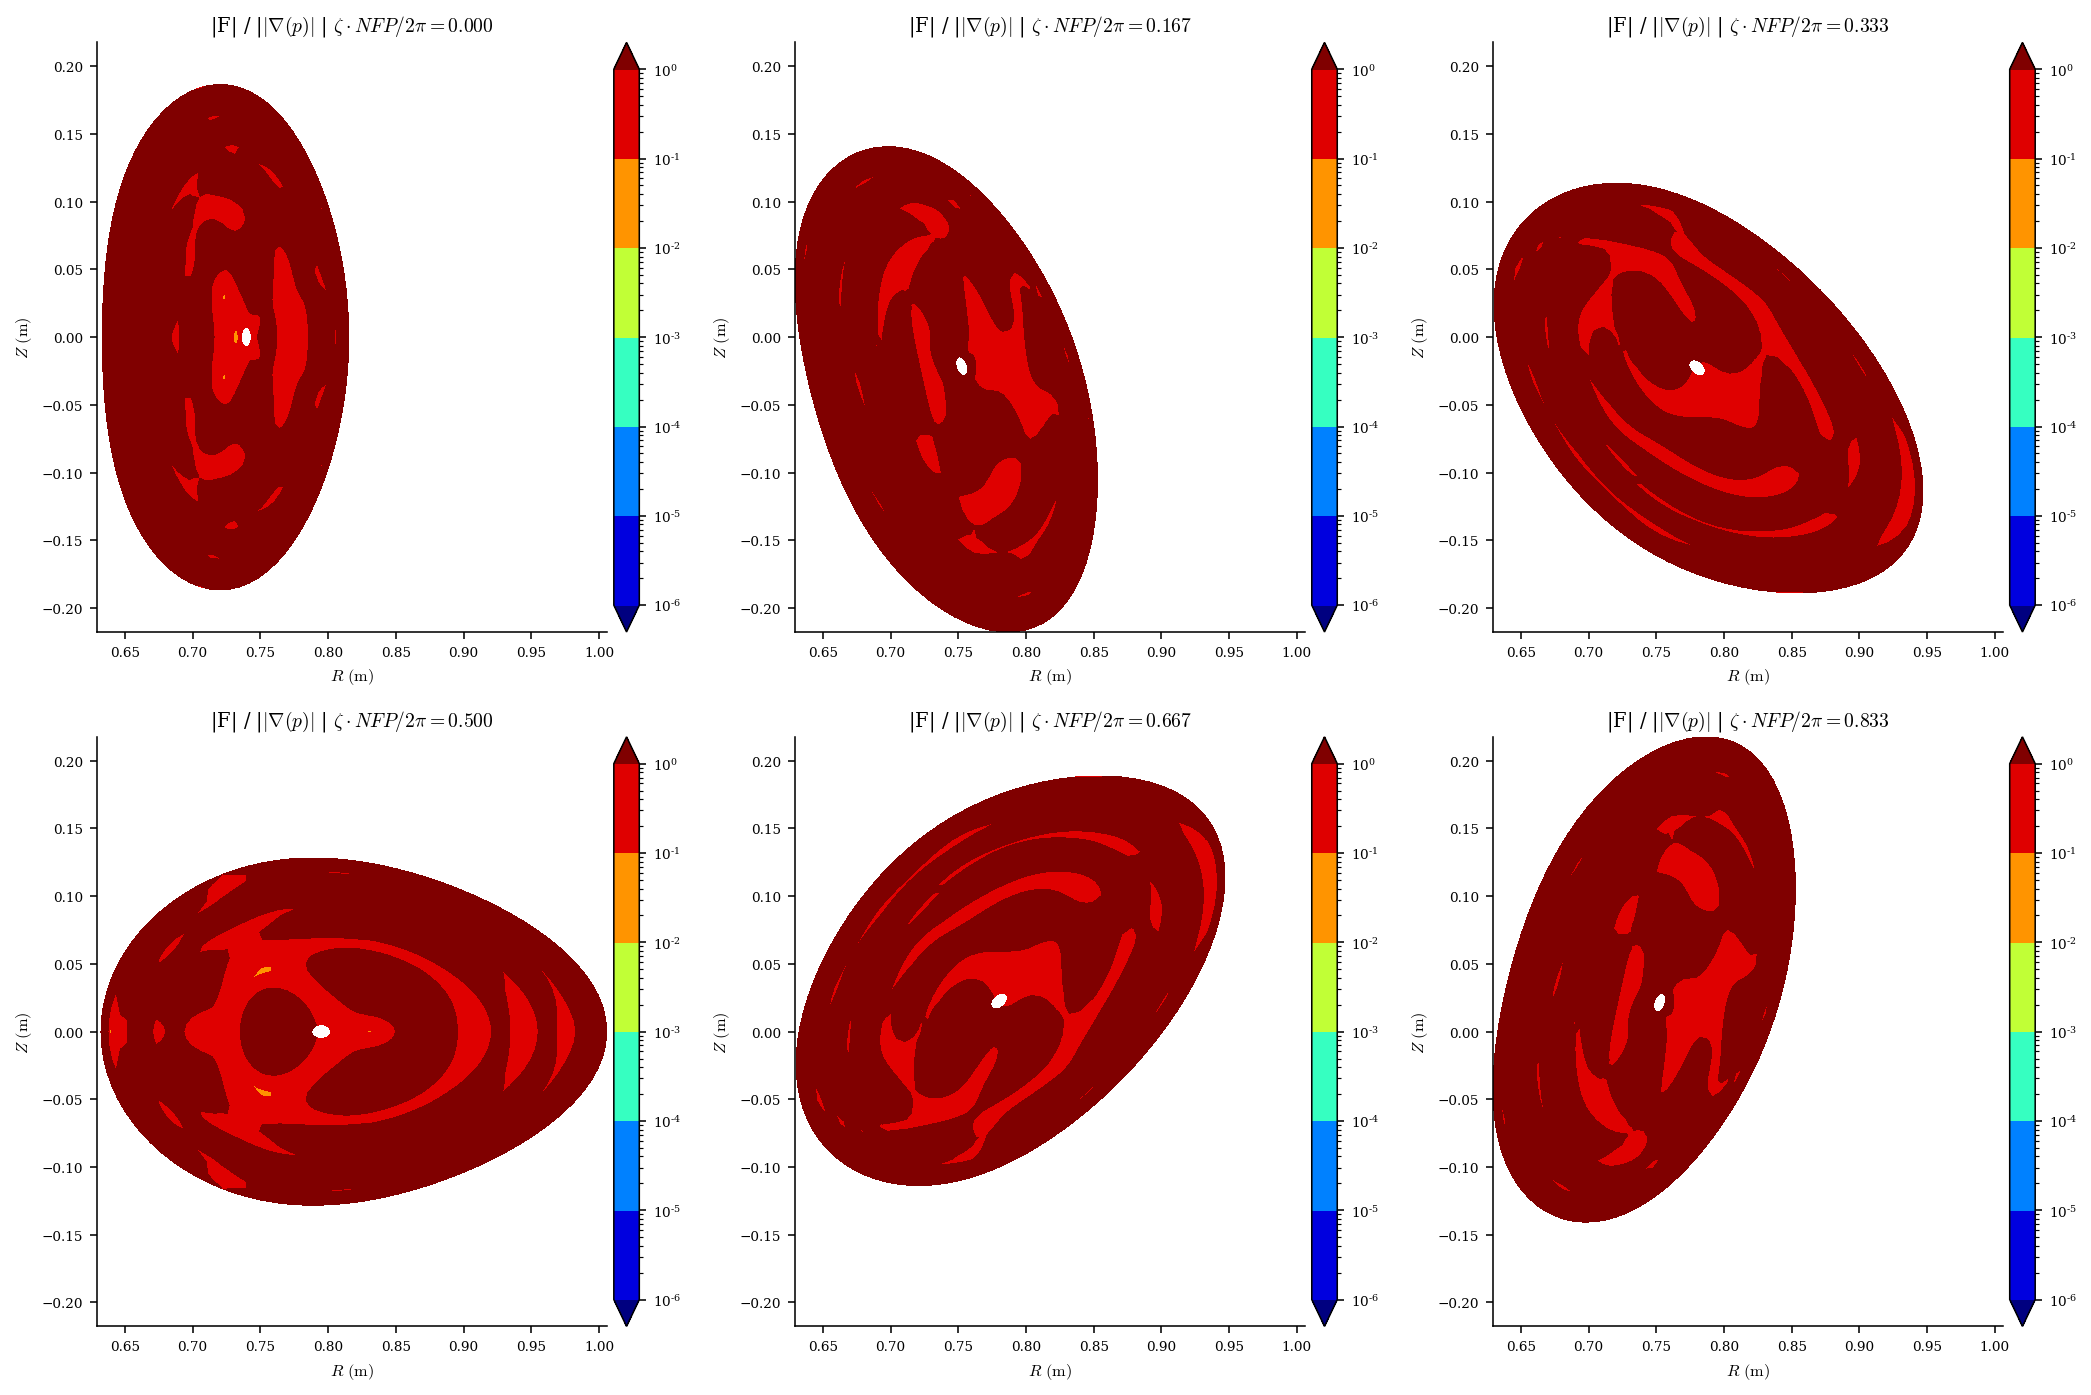

In [98]:
plot_section(eq, "|F|", log=True, norm_F=True)

(<Figure size 2256x1692 with 6 Axes>,
 array([<AxesSubplot:xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <AxesSubplot:xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <AxesSubplot:xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <AxesSubplot:xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <AxesSubplot:xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <AxesSubplot:xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>],
       dtype=object))

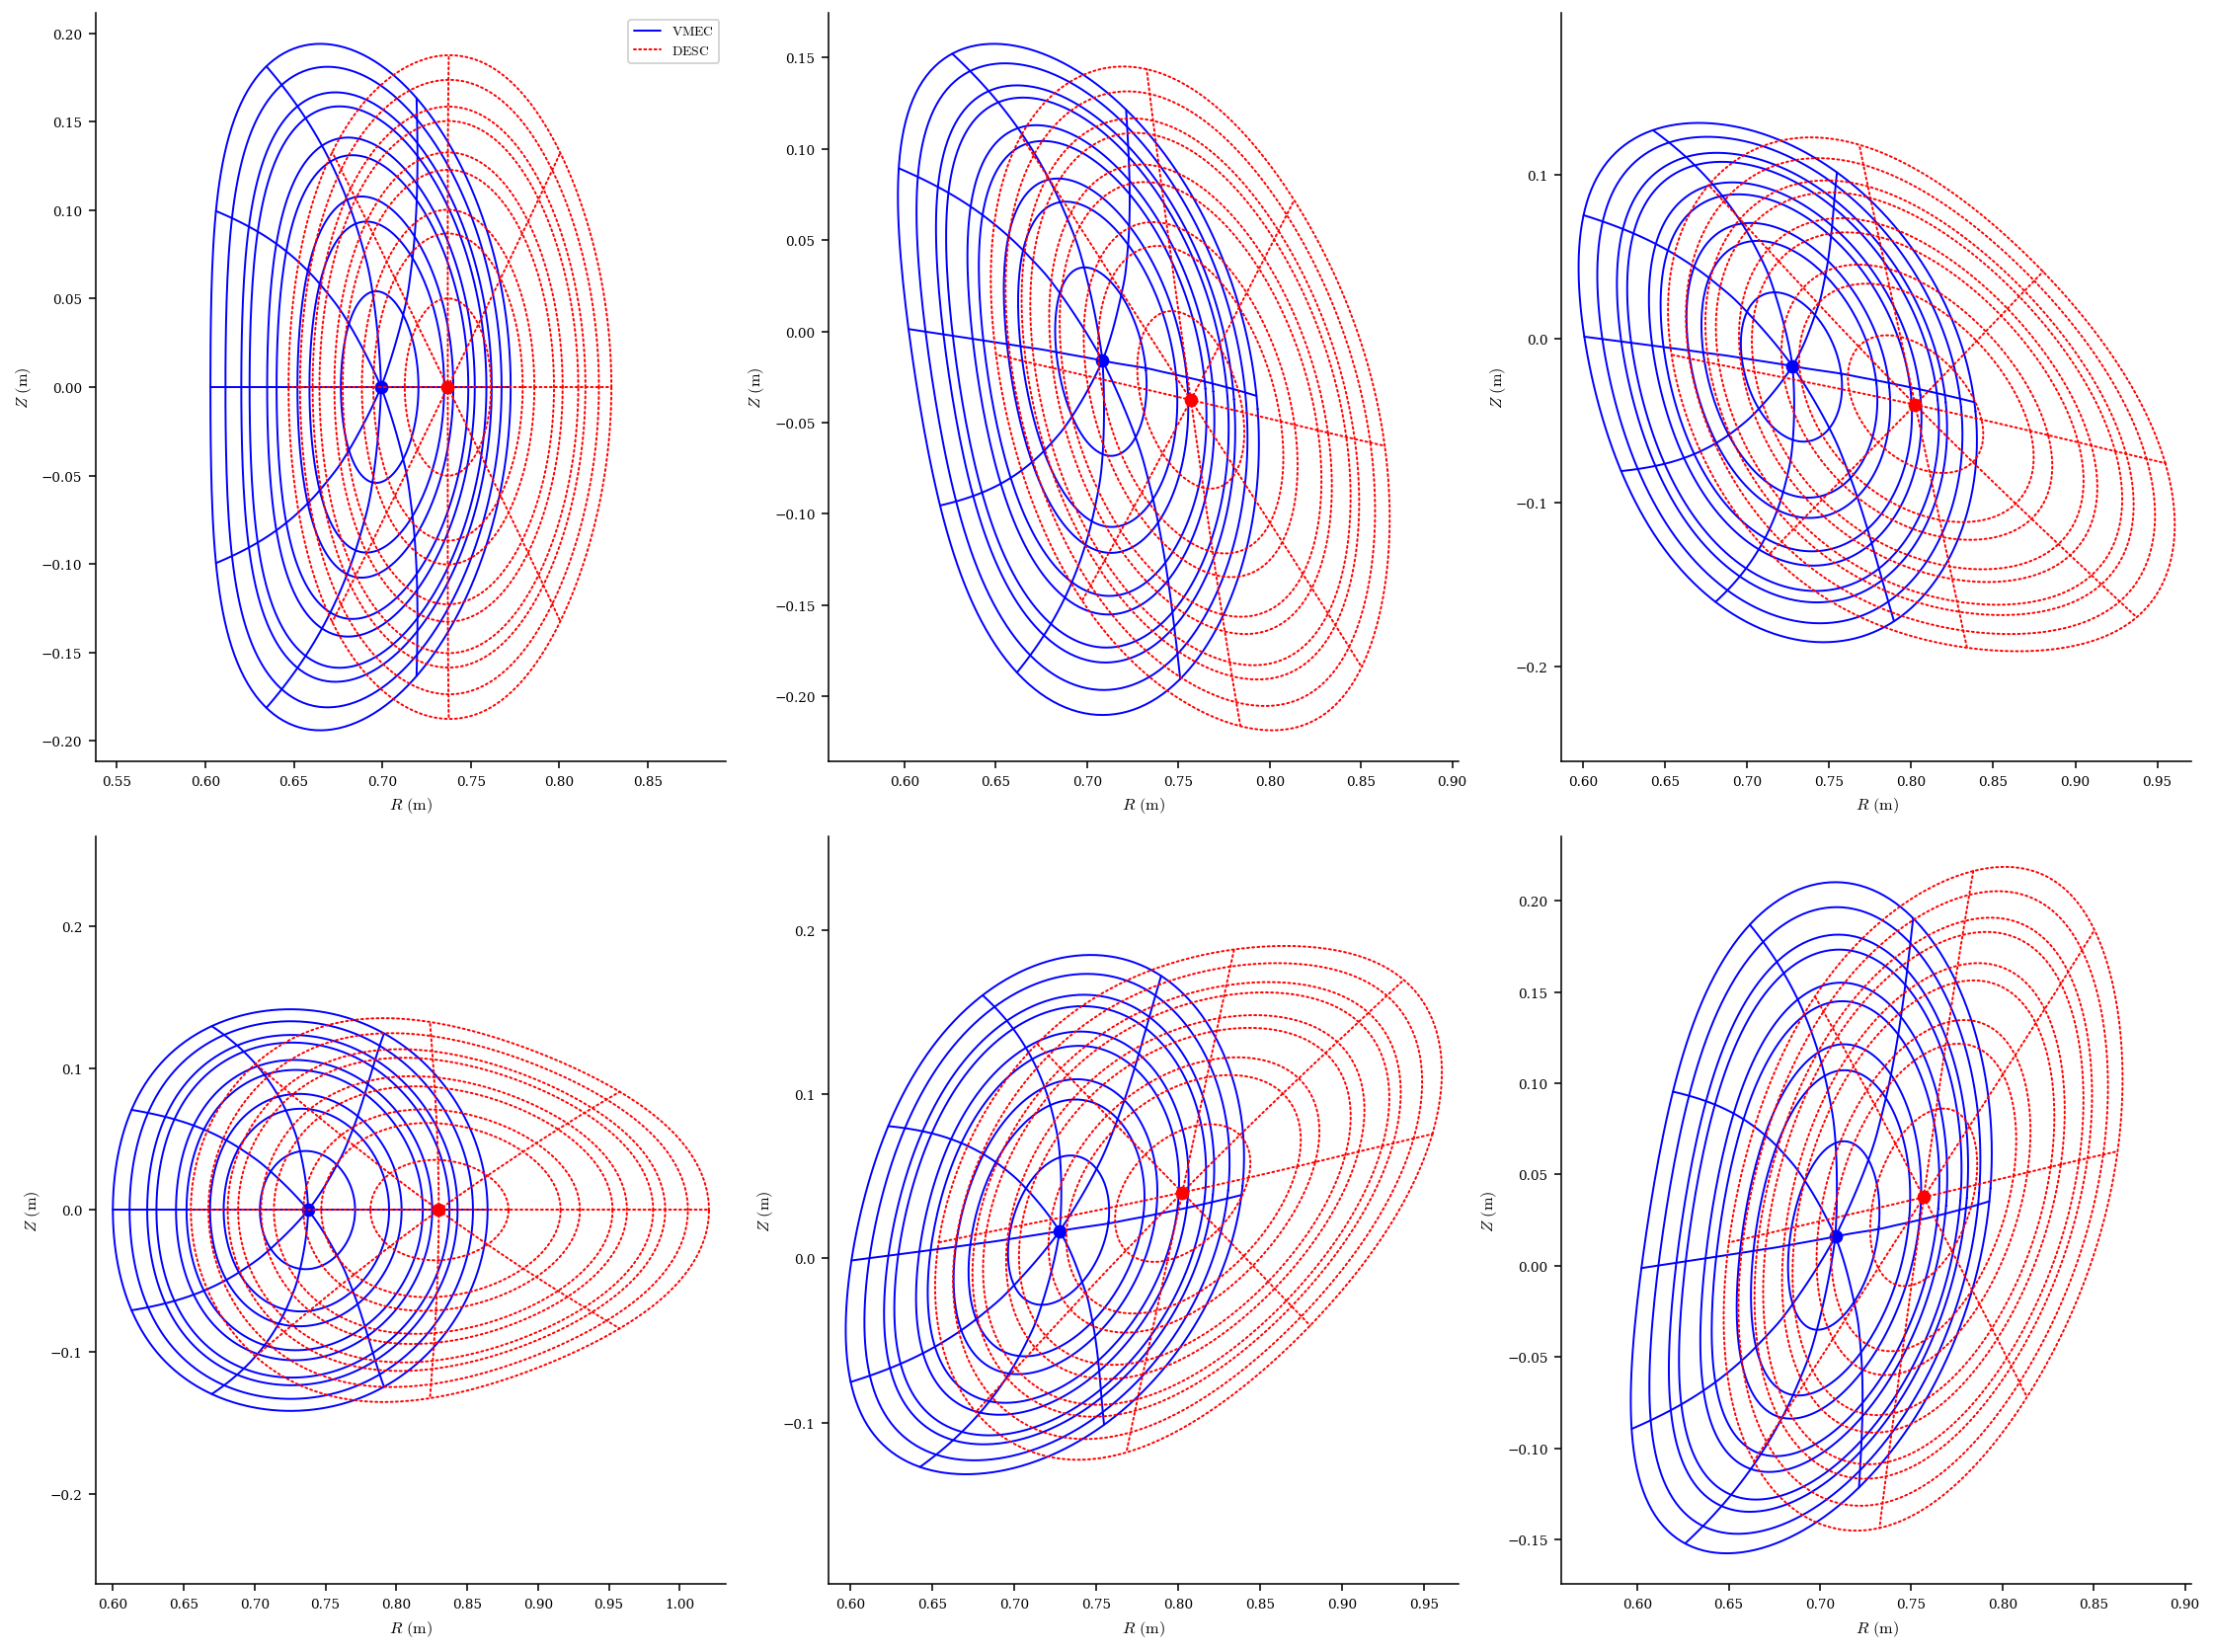

In [153]:
eqi = eq.copy()
eqi.x = eq.x0
VMECIO.plot_vmec_comparison(eqi, "../../educational_VMEC/test/wout_test_vac.vmec.nc")

In [120]:
nsource = 20**2
neval = 10**2
r1 = np.random.random((nsource,3))
r2 = np.random.random((neval,3))
J = np.random.random((nsource,3))

In [81]:
%%timeit
rr = r2[:,np.newaxis] - r1[np.newaxis]
a = np.cross(J,rr)
b = np.linalg.norm(rr, axis=-1)
b = b*b*b
B = np.sum(a/b[:,:,np.newaxis], axis=1)

8.23 s ± 121 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [121]:
@jax.jit
def biot(r1,r2,J):
    rr = r2[:,np.newaxis] - r1[np.newaxis]
    a = jnp.cross(J,rr)
    b = jnp.linalg.norm(rr, axis=-1)
    b = b*b*b
    B = jnp.sum(a/b[:,:,np.newaxis], axis=1)
    return B

In [122]:
B = biot(r1,r2,J).block_until_ready()

In [123]:
B.shape

(100, 3)

In [62]:
%%timeit 


55.5 ms ± 548 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [57]:
a.shape

(1000, 1000)

In [25]:
def C0(R,NFP):
    return (R**NFP - R**-NFP)/(2*NFP)

def C1(R,NFP):
    return (-(NFP-1)*R**(NFP+2) + (NFP+1)*R**NFP - (NFP+1)*R**(-NFP+2) + (NFP-1)*R**-NFP)/(8*NFP*(NFP**2-1))

def C0_R(R,NFP):
    fun = lambda R: C0(R,NFP)
    return jax.jvp(fun, (R,), (jnp.ones_like(R),))[1]

def C1_R(R,NFP):
    fun = lambda R: C1(R,NFP)
    return jax.jvp(fun, (R,), (jnp.ones_like(R),))[1]

def phic(R, Z, NFP):
    return Z**2/2*C0(R,NFP) + C1(R,NFP)

def phis(R,Z,NFP):
    return Z**3*R/6*C0_R(R,NFP) + Z*R*C1_R(R,NFP) -2*Z*C1(R,NFP)

def phiext(R,phi,Z,NFP,a,b,I):
    
    subfun = lambda R,phi,Z: (phis(R,Z,NFP)*jnp.sin(NFP*phi) + phic(R,Z,NFP)*jnp.cos(NFP*phi))
    ddz = jax.jvp(subfun,(R,phi,Z),(jnp.zeros_like(R), jnp.zeros_like(phi), jnp.ones_like(Z)))[1]
    ddphi = jax.jvp(subfun,(R,phi,Z),(jnp.zeros_like(R), jnp.ones_like(phi), jnp.zeros_like(Z)))[1]
    out = I/(2*np.pi)*(phi + a*ddz + b/NFP*ddphi)
    return out

def BR(R,phi,Z,NFP,a,b,I):
    fun = lambda R: phiext(R,phi,Z,NFP,a,b,I)
    return jax.jvp(fun, (R,), (jnp.ones_like(R),))[1]

def Bphi(R,phi,Z,NFP,a,b,I):
    fun = lambda phi: phiext(R,phi,Z,NFP,a,b,I)
    return 1/R*jax.jvp(fun, (phi,), (jnp.ones_like(phi),))[1]

def BZ(R,phi,Z,NFP,a,b,I):
    fun = lambda Z: phiext(R,phi,Z,NFP,a,b,I)
    return jax.jvp(fun, (Z,), (jnp.ones_like(Z),))[1]

@jit
def rhs(p,rz,NFP,a,b,I):
    r,z = rz.reshape((2,-1))
    br = BR(r,p,z,NFP,a,b,I)
    bp = Bphi(r,p,z,NFP,a,b,I)
    bz = BZ(r,p,z,NFP,a,b,I)
    return jnp.array([r*br/bp,r*bz/bp]).flatten()
    

def rk4step(fun, h, t, y, args):
    k1 = fun(t,y,*args)
    k2 = fun(t+h/2, y+h*k1/2,*args)
    k3 = fun(t+h/2, y+h*k2/2,*args)
    k4 = fun(t+h, y+h*k3,*args)
    return t + h, y+1/6*h*(k1+2*k2+2*k3+k4)
    
a = -1.495873
b = -3.270651
I=1.0
NFP = 5
args = (a,b,I,NFP)

In [26]:
Bphi(1.,0.,0.,*args)

DeviceArray(0.79577472, dtype=float64)

In [162]:
def fun1(x, y=4):
    if y:
        return x + y

def fun2(x):
    return x + 4

In [163]:
jax.make_jaxpr(fun1)(1.0)

{ lambda  ; a.
  let b = add a 4.0
  in (b,) }

In [164]:
jax.make_jaxpr(fun2)(1.0)

{ lambda  ; a.
  let b = add a 4.0
  in (b,) }